# Group Project 2
By Rajvee, Bianca, Nazim, Arjun, Ziad


# 1 Imports

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import seaborn as sns
import scipy.stats as st
import lightgbm as lgb

from google.colab import drive
from pathlib import Path
from tqdm import tqdm
from dataclasses import dataclass, asdict
from sklearn.linear_model import ElasticNet, ElasticNetCV, LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from scipy.stats import spearmanr
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.feature_selection import mutual_info_regression

import warnings
warnings.filterwarnings("ignore")

# 2 Project Directory Structure

In [ ]:
drive.mount('/content/drive')

# Load data files
BASE_DIR: Path = Path("/content/drive/MyDrive/ML_Hull_Tactical_Group_Project")
train = pd.read_csv(os.path.join(f"{BASE_DIR}/train.csv"))

# Enforce chronological order
train = train.sort_values("date_id").reset_index(drop=True)

# To confirm date_id increases by exactly 1 at every step.
# Confirms no missing days and no duplicates
assert train['date_id'].diff().dropna().eq(1).all()

# Basic checks
print(train.columns.tolist())
print(len(train))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['date_id', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'E1', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E2', 'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'M1', 'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'M17', 'M18', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'P1', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S11', 'S12', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'V1', 'V10', 'V11', 'V12', 'V13', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']
9021


# 3 Dataset Loading/Creating Helper Functions (Kaggle)

In [ ]:
def load_trainset() -> pd.DataFrame:
    """
    Loads and preprocesses the training dataset.
    """
    train_path = BASE_DIR / "train.csv"

    df = (
        pd.read_csv(train_path)
        .rename(columns={'market_forward_excess_returns': 'target'})
    )

    # Enforce numeric types (excluding date_id)
    cols = df.columns.difference(['date_id'])
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

    return df


def train_test_split_timewise(df: pd.DataFrame, n_test: int = 100):
    """
    Splits data into train and test sets, preserving temporal order.
    The last n_test observations are used as the test set.
    """
    df = df.sort_values("date_id").reset_index(drop=True)

    assert 0 < n_test < len(df)
    train = df.iloc[:-n_test].copy()
    test  = df.iloc[-n_test:].copy()

    return train, test

# 4 Non-Kaggle Functions

## 4.1 Validation Metrics

In [ ]:
# -------------------------------------------------
# Model evaluation on validation data
# -------------------------------------------------
def train_and_evaluate(model, model_type):
    """
    Evaluates a fitted model on the validation set.

    Computes:
    - MAE
    - RMSE
    - R2
    - Pearson correlation between predictions and true values

    model_type selects between:
    - "scaled": linear / regularised models
    - "nl": non-linear models
    """

    if model_type == "scaled":
      pred_val   = model.predict(X_val_scaled)
    elif model_type == "nl":
      pred_val   = model.predict(X_val_nl)
    else:
        raise ValueError("model_type must be 'scaled' or 'nl'")

    mae  = mean_absolute_error(y_val, pred_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred_val))
    r2   = r2_score(y_val, pred_val)

    # safe correlation
    corr = np.nan
    if np.std(pred_val) > 0 and np.std(y_val) > 0:
        corr = np.corrcoef(pred_val, y_val)[0, 1]

    results =  {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "Correlation": corr
    }

    return results

## 4.2 Information Coefficient (IC)

In [ ]:
# -------------------------------------------------
# Overfitting diagnostics using Information Coefficient
# -------------------------------------------------
def check_overfitting(model, model_type):
    """
    Computes overfitting diagnostics:
    - Train IC (Spearman rank correlation)
    - Validation IC
    - IC gap (train - validation)
    - Train and validation RMSE

    IC (Spearman rank correlation) is used to assess whether the model
    correctly ranks outcomes rather than predicting exact values, which
    is particularly appropriate for financial return prediction.

    Overfitting is indicated by a large gap between train and validation IC,
    while underfitting is indicated by consistently low IC values.
    """

    # Choose the correct datasets
    if model_type == "scaled":
      pred_train = model.predict(X_train_scaled)
      pred_val   = model.predict(X_val_scaled)
    elif model_type == "nl":
      pred_train = model.predict(X_train_nl)
      pred_val   = model.predict(X_val_nl)
    else:
        raise ValueError("model_type must be 'scaled' or 'nl'")

    # Metrics
    train_ic = spearmanr(pred_train, y_train)[0]
    val_ic   = spearmanr(pred_val, y_val)[0]

    rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
    rmse_val   = np.sqrt(mean_squared_error(y_val, pred_val))

    return {
        "train_ic": train_ic,
        "val_ic": val_ic,
        "ic_gap": train_ic - val_ic,
        "rmse_train": rmse_train,
        "rmse_val": rmse_val
    }


## 4.3 Feature Engineering

In [ ]:
# -------------------------------------------------
# Feature engineering pipeline (train + test safe)
# -------------------------------------------------
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Constructs lagged, rolling, and interaction features using
    only information available at each point in time to avoid
    look-ahead bias.
    """
    df = df.copy()

    # ==============================
    # 0. TARGET SHIFT to prevent look-ahead bias
    # ==============================
    # Lag target so that all features at time t use information up to t-1
    target_shifted = df["target"].shift(1)

    # ==============================
    # 1. TARGET DYNAMICS
    # ==============================
    # Rolling moments capture short- and medium-term return behaviour
    df["roll_mean_5"]  = target_shifted.rolling(5).mean()
    df["roll_mean_10"] = target_shifted.rolling(10).mean()
    df["roll_mean_20"] = target_shifted.rolling(20).mean()

    df["roll_vol_5"]   = target_shifted.rolling(5).std()
    df["roll_vol_10"]  = target_shifted.rolling(10).std()
    df["vol_20"]       = target_shifted.rolling(20).std()

    df["vol_ratio_5_20"] = df["roll_vol_5"] / (df["vol_20"] + 1e-8)
    df["zscore_5"]       = (target_shifted - df["roll_mean_5"]) / (df["roll_vol_5"] + 1e-8)

    df["mom_5"]   = target_shifted.rolling(5).sum()
    df["mom_20"]  = target_shifted.rolling(20).sum()
    df["mom_osc"] = df["mom_5"] / (df["mom_20"] + 1e-8)

    df["abs_return"] = target_shifted.abs()
    df["diff_1"] = target_shifted.diff(1)
    df["diff_5"] = target_shifted.diff(5)

    vol10 = df["roll_vol_10"]

    # Volatility regime indicator using expanding median
    # Ensures regime classification uses only past information
    median_vol = vol10.expanding().median()
    df["is_high_vol"] = (df["roll_vol_10"] > median_vol).astype(int)

    # ==============================
    # 2. MACRO SPREADS
    # ==============================
    # Term and maturity spreads commonly used as macro predictors
    df["E_spread"] = df["E10"] - df["E1"]
    df["M_spread"] = df["M15"] - df["M3"]

    # ==============================
    # 3. VIX / V-SERIES
    # ==============================
    # Cross-sectional dispersion of volatility proxies
    # Serves as a VIX-like uncertainty indicator
    # Rolling dynamics and shocks for key volatility proxy (V13)
    V_cols = [c for c in df.columns if c.startswith("V")]
    df["VIX_like"] = df[V_cols].std(axis=1)

    if "V13" in df.columns:
        df["V13_roll5"]  = df["V13"].rolling(5).mean()
        df["V13_roll20"] = df["V13"].rolling(20).mean()
        df["V13_shock"]  = df["V13"] - df["V13"].rolling(5).mean()
    else:
        df["V13_roll5"]  = df["V13_roll20"] = df["V13_shock"]  = 0

    # ==============================
    # 4. M-SERIES
    # ==============================
    # Rolling trends, z-scores, and short-term shocks
    if "M4" in df.columns:
        df["M4_roll5"]  = df["M4"].rolling(5).mean()
        df["M4_roll20"] = df["M4"].rolling(20).mean()
        df["M4_z"]      = (df["M4"] - df["M4"].rolling(20).mean()) / \
                          (df["M4"].rolling(20).std() + 1e-8)
        df["M4_shock"] = df["M4"] - df["M4"].rolling(5).mean()
    else:
        df["M4_roll5"] = df["M4_roll20"] = df["M4_z"] = df["M4_shock"] = 0

    # ==============================
    # 5. FILTERED E-SERIES
    # ==============================
    # Rolling medians reduce sensitivity to outliers
    for col in ["E6", "E8", "E11", "E12"]:
        if col in df.columns:
            df[f"{col}_med5"] = df[col].rolling(5).median()
        else:
            df[f"{col}_med5"] = 0

    # ==============================
    # 6. NONLINEAR INTERACTIONS
    # ==============================
    # Interaction terms capture conditional effects
    # (e.g. momentum behaving differently under high volatility)
    df["mom_vol_interact"] = df["mom_5"] * df["roll_vol_5"]
    df["return_shock"] = df["diff_1"] * df["diff_5"]

    df["mom_sign"] = np.sign(df["mom_5"])

    df["E_spread_vol"] = df["E_spread"].rolling(10).std()

    df["vol_ratio_10_20"] = df["roll_vol_10"] / (df["vol_20"] + 1e-8)
    df["vol_slope"] = df["roll_vol_10"] - df["roll_vol_5"]

    df["VIX_slope"] = df["VIX_like"].diff()
    df["spread_vol_interact"] = df["E_spread"] * df["roll_vol_10"]
    df["acceleration"] = df["diff_1"].diff()

    # Replace NaNs arising from rolling windows with zeros
    # Early periods contain limited information by construction
    df = df.fillna(0)

    return df

# 5 Looking at the Data

## 5.1 Testset

Since the dataset represents time-series data, a random train-test split would introduce look-ahead bias. To ensure a realistic and leakage-free evaluation, a chronological hold-out approach was used.

The full dataset was first sorted by date_id to preserve temporal order. The last 100 observations, corresponding to the most recent time periods, were assigned to the test set, while all earlier observations were used for model training.

In [ ]:
# Load full dataset and create a time-ordered train–test split
df = load_trainset()

# The final 100 observations are reserved as an out-of-sample test set
train_pd, test_pd = train_test_split_timewise(df, n_test=100)

In [ ]:
print(f"Size of the train set: {train_pd.shape}")
print(f"Size of the test set: {test_pd.shape}")

Size of the train set: (8921, 98)
Size of the test set: (100, 98)


In [ ]:
print(f"Maximum number of train set date_id: {train_pd["date_id"].max()}")
print(f"Minimum number of test set date_id: {test_pd["date_id"].min()}")

Maximum number of train set date_id: 8920
Minimum number of test set date_id: 8921


In [ ]:
train_pd = train_pd.sort_values('date_id').reset_index(drop=True)
test_pd = test_pd.sort_values('date_id').reset_index(drop=True)

# 6 Exploratory Data Analysis (EDA) and Data Visualisation

This section explores the dataset through visualisations and summary statistics to understand patterns, relationships, and data distribution before feature engineering.

## 6.1 Statistical summary of the 'target' variable

In [ ]:
# the statistics
print(
    f"Target Mean: {train_pd["target"].mean():.6f}\n"
    f"Target Standard Deviation: {train_pd["target"].std():.6f}\n"
    f"Target Skew: {train_pd["target"].skew():.6f}\n"
    f"Target Kurtosis: {train_pd["target"].kurtosis():.6f}"
)

Target Mean: 0.000043
Target Standard Deviation: 0.010595
Target Skew: -0.176334
Target Kurtosis: 2.221308




*   The mean implies the dataset is centred around zero.

*   The daily excess returns vary by roughly 1% around the mean, indicating a moderate level of market volatility.

*   Slightly negative skew means returns have a small tendency for larger negative outliers — losses are slightly more extreme than gains.

*   A kurtosis > 0 suggests fat tails — extreme returns occur more often than under a normal curve.

## 6.2 Histogram of the Statistical Summary of the 'target' Variable

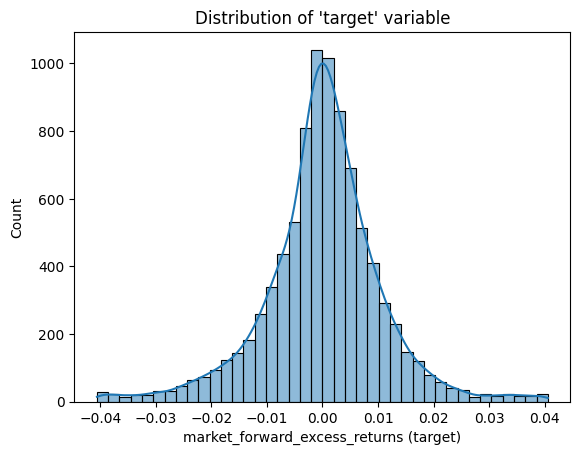

In [ ]:
# to plot the histogram
sns.histplot(train_pd['target'], bins=40, kde=True)
plt.title("Distribution of 'target' variable")
plt.xlabel("market_forward_excess_returns (target)")
plt.ylabel("Count")
plt.show()

*   The distribution of 'target' is approximately symmetric and centred around zero, indicating that most returns are small with few extreme values.

*   Overall, the 'target' variable exhibits a stable and near-normal distribution.






## 6.3 Understanding the Feature Data: Feature Variance Analysis

Features with extremely low variance contain little information and are unlikely to contribute meaningfully to return prediction. Feature variance analysis was therefore used as an exploratory diagnostic to identify near-constant variables and extreme outliers, rather than as a direct feature elimination rule.

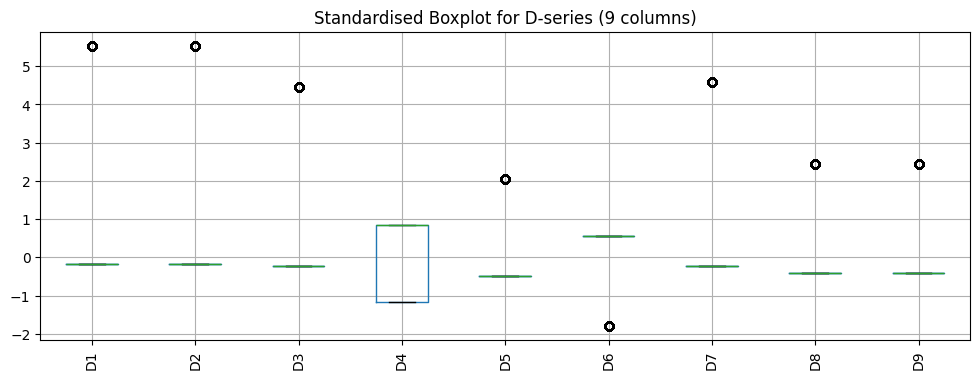

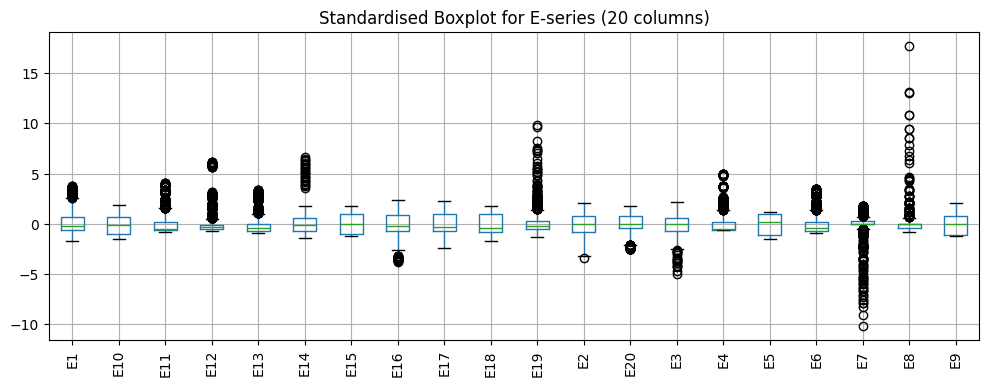

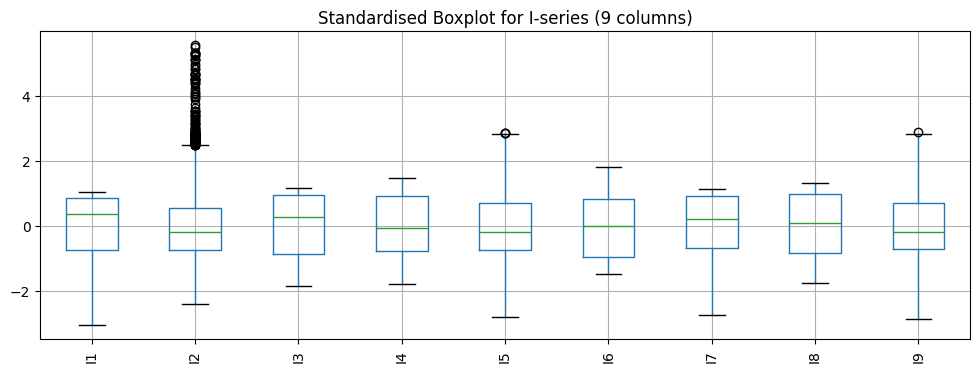

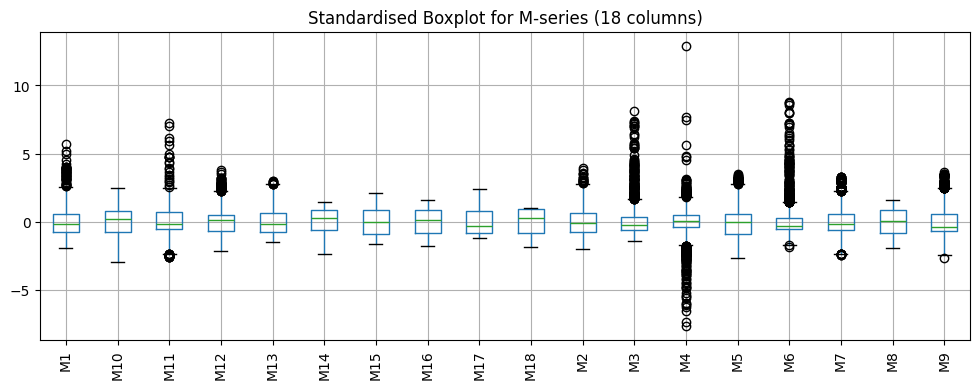

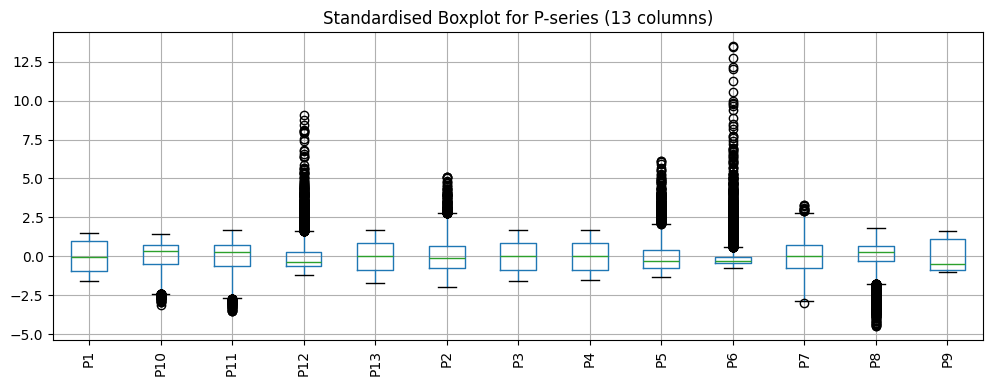

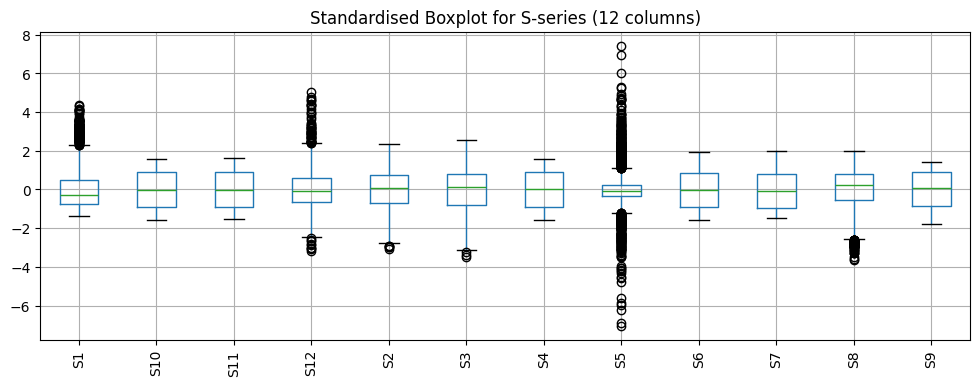

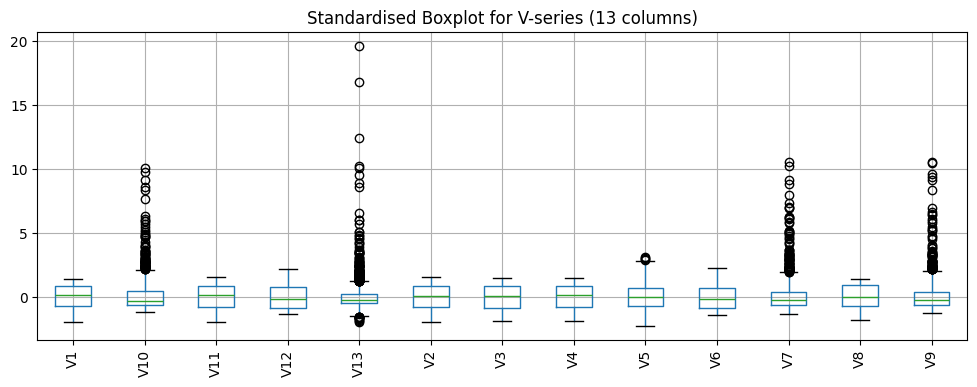

In [ ]:
# Automatically detect series groups
series_groups = {
    'D-series': [c for c in train_pd.columns if c.startswith('D')],
    'E-series': [c for c in train_pd.columns if c.startswith('E')],
    'I-series': [c for c in train_pd.columns if c.startswith('I')],
    'M-series': [c for c in train_pd.columns if c.startswith('M')],
    'P-series': [c for c in train_pd.columns if c.startswith('P')],
    'S-series': [c for c in train_pd.columns if c.startswith('S')],
    'V-series': [c for c in train_pd.columns if c.startswith('V')],
}

from sklearn.preprocessing import StandardScaler

def plot_boxplots(df, groups):
    for group_name, cols in groups.items():
        if len(cols) == 0:
            continue

        data = df[cols].dropna()
        scaled = pd.DataFrame(
            StandardScaler().fit_transform(data),
            columns=cols
        )

        plt.figure(figsize=(12,4))
        scaled.boxplot()
        plt.title(f"Standardised Boxplot for {group_name} ({len(cols)} columns)")
        plt.xticks(rotation=90)
        plt.show()

# Generate all plots
plot_boxplots(train_pd, series_groups)


### 6.3.1 Analyses of Boxplots
---
1. ***D-Series Boxplot (D1-D9):***

**Type:** Binary / indicator features (-1, 0, 1)

**Observation:**
- Most columns are constant or near-constant (flat line at 0).
- Occasional extreme points at +1 or -1.
- D4 and D6 show some variation, but still very limited.

**Interpretation:**
- The near-zero variance suggests these variables are rarely active and therefore contribute little information on average.
- As binary event indicators, any predictive value would be episodic rather than persistent.

**Conclusion: Likely low average predictive contribution, but may still be relevant in nonlinear models or interaction terms.**

---

2. ***E-Series Boxplot (E1-E20):***

**Type: Economic / Expectation Variables**

**Observation:**
- Moderate variance for E1-E5 with relatively stable distributions.
- Very large variance and heavy outliers in E7-E12 and E19.

**Interpretation:**
- The presence of heavy tails suggests sensitivity to rare macroeconomic shocks.
- While raw values are noisy, these variables may still contain signal once smoothed or normalised.

**Conclusion: Raw features are unstable, but engineered versions (e.g. rolling means, z-scores, spreads) are more likely to be informative.**

---

3. ***I-Series (I1-I9):***

**Type: Interest / Inflation-like Variables**

**Observation:**
- Stable distributions
- Moderate variance
- Outliers are present but controlled.

**Interpretation:**
- These features exhibit relatively stationary behaviour, consistent with macroeconomic rate or inflation series.

**Conclusion: Potentially informative macro signals, particularly for medium-term return dynamics.**

---

4. ***M-Series Boxplot (M1-M12):***

**Type: Momentum / Market Dynamics**

**Observation:**
- Medium-to-high variance across many columns.
- Several features cluster around 0 but exhibit heavy-tailed outliers.
- Extreme spikes in some columns

**Interpretation:**
- The high variance indicates sensitivity to market regimes and shocks.
- While raw values are noisy, momentum-based transformations may capture meaningful dynamics.

**Conclusion: Could be useful after feature engineering, especially for models capable of handling nonlinear effects.**

---

4. ***P-series (P1-P13):***

**Type: Price / Positioning-like Variables**

**Observation:**
- Mixed behaviour.
- Some columns show tight distributions (P1-P4).
- Others show strong outliers (P12, P6).
- Moderate variance overall.

**Interpretation:**
- The heterogeneous distributions suggest that predictive value may be feature-specific rather than group-wide.

**Conclusion: Selective predictive potential, warranting feature-level rather than series-level selection.**

---

5. **S-series (S1-S12):**

**Type: Sentiment / Sector-level Indicators**

**Observation:**
- Mostly centred around 0.
- Heady tails in some columns
- Tight interquartile ranges (IQR) but heavy tails.

**Interpretation:**
- These features appear stable most of the time but occasionally experience large shocks, which may be relevant for regime shifts.

**Conclusion: Moderate predictive potential, particularly when combined with volatility or regime features.**

---

6. ***V-series (V1-V13):***

**Type: Volatility / Risk Measures**

**Observation:**
- Very high variance, especially V13 (extreme tails).
- Strong outliers across almost all columns; extremely heavy tails.
- Wide and unstable box shapes.

**Interpretation:**
- High variance reflects the intrinsic nature of volatility-related measures rather than noise alone.

**Conclusion: Raw volatility measures are unstable, but derived volatility features (rolling variance, slopes, interactions) are more suitable for prediction.**



## 6.4 Correlation of the Feature Data with the 'target' Variable

To assess the linear association between each feature and the target variable, Pearson correlations were computed and used as an initial screening tool. Given the noisy nature of financial return data, even small correlations may be statistically meaningful. This analysis is therefore used for exploratory ranking rather than definitive feature selection.


In [ ]:
# Define feature columns
feature_cols = [
    c for c in train_pd.columns
    if c not in ['date_id', 'forward_returns', 'risk_free_rate', 'target']
]

# Base describe() statistics
feature_stats = train_pd[feature_cols].describe().T  # transpose for readability

# Add skewness & kurtosis
feature_stats['skew']     = train_pd[feature_cols].skew()
feature_stats['kurtosis'] = train_pd[feature_cols].kurtosis()

# Remove forward_returns for correlation (prevents leakage)
clean_features = [
    c for c in feature_cols
    if c != 'forward_returns'
]

# Compute correlation WITH target
corr_with_target = train_pd[clean_features].corrwith(train_pd['target'])

# Add correlations to stats table
feature_stats['corr_with_target'] = corr_with_target

# Sort by absolute correlation strength
feature_stats = (
    feature_stats
    .round(4)
    .sort_values(by='corr_with_target', key=lambda s: s.abs(), ascending=False)
)

# output
feature_stats.head()


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis,corr_with_target
M4,7915.0000000000,-0.0036000000,1.0984000000,-9.3899000000,-0.4911000000,0.0527000000,0.5618000000,13.1200000000,-0.4958000000,8.9763000000,-0.0664000000
V13,7410.0000000000,0.1163000000,1.3365000000,-4.7703000000,-0.6920000000,-0.2165000000,0.4891000000,24.1515000000,3.9788000000,36.1196000000,0.0626000000
M1,3374.0000000000,-0.6058000000,1.0072000000,-2.5229000000,-1.3460000000,-0.7643000000,-0.0168000000,5.1259000000,0.9185000000,1.5418000000,0.0470000000
S5,7410.0000000000,0.0325000000,1.1349000000,-13.1246000000,-0.3455000000,-0.0310000000,0.3617000000,10.3708000000,-0.2120000000,14.5293000000,0.0394000000
S2,7915.0000000000,0.0216000000,1.0280000000,-3.4298000000,-0.6705000000,0.1276000000,0.7846000000,2.3920000000,-0.3482000000,-0.4360000000,-0.0378000000


### 6.4.1 Barplot of the 15 most correlated features 'target'

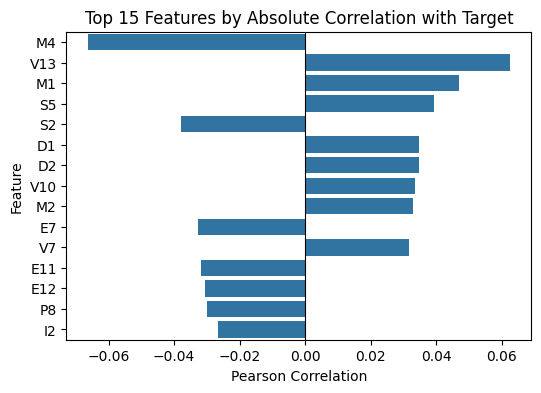

In [ ]:
# Extract correlations (they already exclude forward_returns)
corr_series = feature_stats['corr_with_target']

# Select top 15 most correlated features
# Features are ranked by absolute correlation magnitude;
  # the sign of the relationship is ignored at this stage.
top_corr = (
    corr_series
    .reindex(corr_series.abs().sort_values(ascending=False).head(15).index)
)

plt.figure(figsize=(6,4))
sns.barplot(x=top_corr.values, y=top_corr.index)
plt.axvline(0, color='black', linewidth=0.8)
plt.title("Top 15 Features by Absolute Correlation with Target")
plt.xlabel("Pearson Correlation")
plt.ylabel("Feature")
plt.show()


* **M-series variables (notably M4, M1, and M2)** exhibit the largest absolute linear correlations with the target among all features.
This suggests that macro-market dynamics and momentum-related indicators contain relatively stronger linear signal compared to other feature groups, even though the magnitude of the correlations remains modest.

* **Volatility-related variables (V13, V10, V7)** also appear among the most correlated features.
This indicates that market risk and uncertainty measures may play a role in explaining excess returns, consistent with the idea that return predictability varies across volatility regimes.

* **S-series (S5, S2)** as well as selected **D-** and **E-series** variables also appear in the top group.
This highlights the heterogeneous nature of predictive signals, where event indicators, sentiment-like features, and macroeconomic expectations may contribute incremental information despite weak standalone correlations.


**Note:** These correlations are used for exploratory ranking only and do not imply that highly correlated features are retained or that weakly correlated features are discarded.

## 6.5 Missing Values Heatmap

To visually highlight gaps in the dataset, and to identify patterns of missingness that may require imputation or feature exclusion.



In [ ]:
train_pd = train_pd.sort_values("date_id").reset_index(drop=True)
missing_summary = train_pd.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_summary / len(train_pd)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_summary, '% Missing': missing_percentage})
missing_df.head(5)
# sort the dates for the training dataset

,Missing Values,% Missing
E7,6969,78.1190449501
V10,6049,67.8062997422
S3,5733,64.2640959534
M1,5547,62.1791279005
M13,5540,62.1006613608


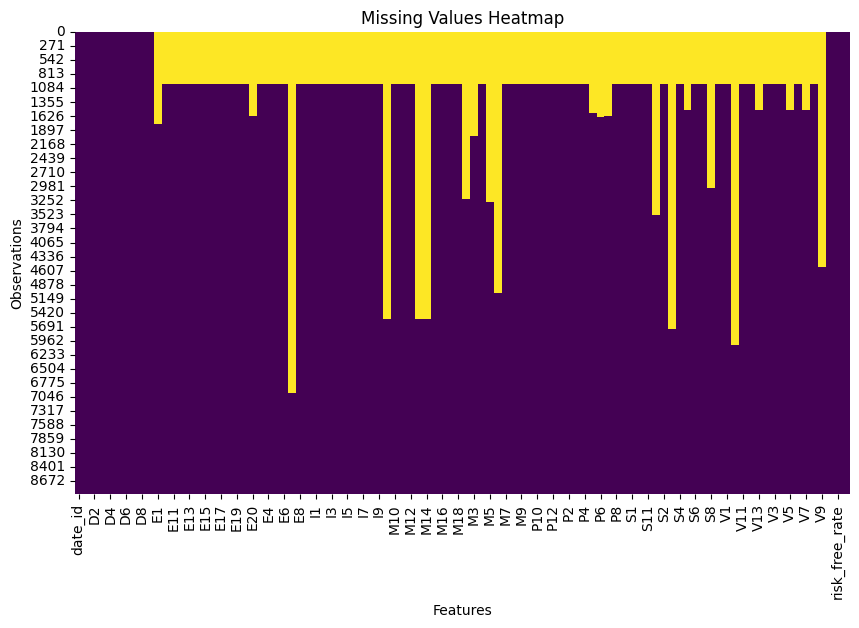

Average missingness across features: 15.75%


In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(train_pd.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.xlabel("Features")
plt.ylabel("Observations")
plt.show()

avg_missing = missing_df['% Missing'].mean()
print(f"Average missingness across features: {avg_missing:.2f}%")

The heatmap shows that missing values are primarily concentrated in the early observations of the dataset. To mitigate the influence of incomplete observations, the initial portion of the dataset was excluded so that model training relied on periods where engineered features are fully populated and stable.

**In addition, the features exhibiting the strongest linear association with the target variable display relatively low levels of missingness. This indicates that the most informative features identified in the correlation analysis are also among the most complete, reducing the risk that missing data disproportionately affects the core predictive signals.**

# 7 Modelling Decisions Based on EDA

This section introduces and justifies the modelling choices made in the project, based on insights from the EDA—such as which feature groups to prioritise, which to reduce, and how missing early rows were handled.

## 7.1 Data Cleaning: Early Missing Observations

Exploratory analysis revealed that missing values were concentrated in the early observations of the dataset. To ensure that model training relied on fully populated and stable features, rows in which all core feature groups (E-V series) were missing were identified and removed.

In [ ]:
# Select only the relevant columns (E1 to V9)
# Columns were selected based on feature group definitions identified during
  # exploratory data analysis and inspection of the raw dataset.

subset_cols = train_pd.loc[:, "E1":"V9"]
all_missing_rows = subset_cols[subset_cols.isnull().all(axis=1)]

# Find rows where values in ALL of those columns are missing
print(f"Total rows where all columns from E1 to V9 are missing: {len(all_missing_rows)}")

# To print the last row:
print(f"Last missing block ends at row: {all_missing_rows.index.max()}")

Total rows where all columns from E1 to V9 are missing: 1006
Last missing block ends at row: 1005


In [ ]:
cutoff_idx = all_missing_rows.index.max() + 1

def load_clean_train(train_pd: pd.DataFrame, cutoff: int) -> pd.DataFrame:
    """
    Removes early observations with fully missing feature blocks
    to ensure stable feature availability.
    """
    return train_pd.iloc[cutoff:].copy().reset_index(drop=True)

train_pd = load_clean_train(train_pd, cutoff_idx)

In [ ]:
print(f"The new length of the Training set {len(train_pd)}")
print(f"The first 5 rows of the mutated Training set: \n{train_pd['date_id'].head(5)}")

The new length of the Training set 7915
The first 5 rows of the mutated Training set: 
0    1006
1    1007
2    1008
3    1009
4    1010
Name: date_id, dtype: int64


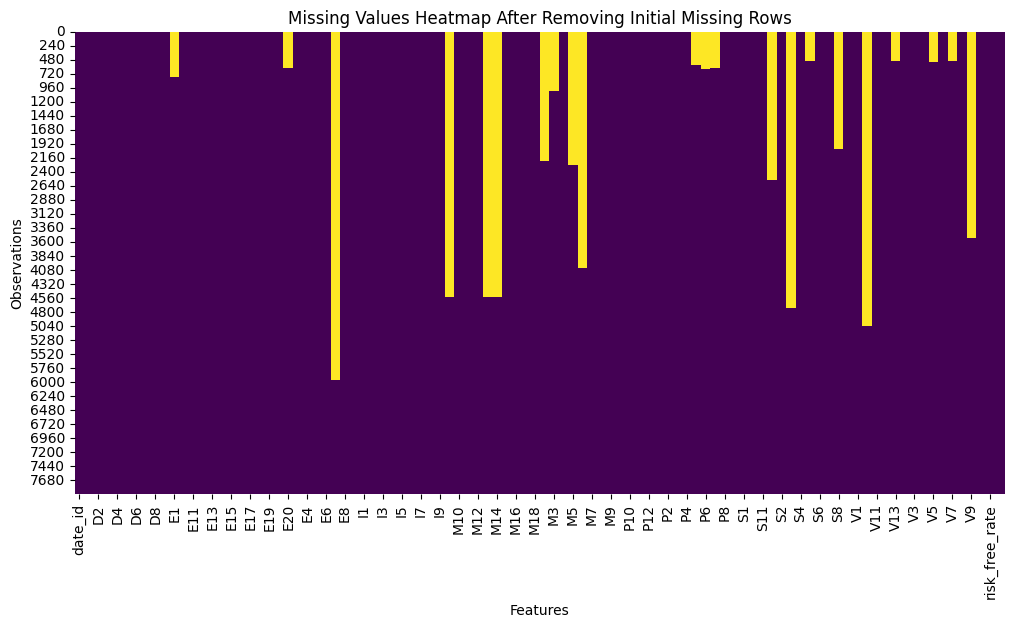

In [ ]:
# Missingness Heatmap After Cleaning
plt.figure(figsize=(12, 6))
sns.heatmap(train_pd.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap After Removing Initial Missing Rows")
plt.xlabel("Features")
plt.ylabel("Observations")
plt.show()

Removing early incomplete observations reduced noise in model estimation and ensured that all models were trained on comparable, information-complete feature sets.

## 7.2 Useful Feature Column List Extraction

The purpose of this section is to screen and prioritise features that exhibit a measurable relationship with the target variable prior to model training.

Each feature column is evaluated using four complementary criteria:

* **Variance:** to remove near-constant features with limited information content

* **Correlation:** to assess linear association with the target

* **Mutual:** information, to capture potential nonlinear dependencies

* **Lasso:** coefficient magnitude, to identify features consistently selected under regularisation

Features that show evidence of relevance across multiple criteria are retained. This multi-stage screening approach reduces dimensionality while avoiding reliance on any single metric, acknowledging that financial return predictability is typically weak and noisy.

In [ ]:
def feature_selection_pipeline(df, target_col="target",
                               var_thresh=0.01,
                               corr_thresh=0.01,
                               mi_quantile=0.25,
                               lasso_alpha=0.0005):

    df = df.copy()

    # -------------------------------
    # 1. Separate X and y
    # -------------------------------
    y = df[target_col]
    cols_to_drop = ["target", "date_id", "forward_returns", "risk_free_rate"]

    X = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

    # ======================================================
    #  A. LOW VARIANCE FILTER
    # ======================================================
    """
    Features that barely change over time carry little predictive information.
    This step removes columns whose variance falls below a minimal threshold (0.01).
    These are often constant or near-constant series.
    """
    stds = X.std()
    low_variance = stds[stds < var_thresh].index.tolist()

    # ======================================================
    #  B. CORRELATION FILTER
    # ======================================================
    """
    For each predictor, its absolute correlation is computer with the target.
    Columns with correlation lower than 0.01 are treated as linearly irrelevant.
    This removes variables that have no measurable linear signal.
    """
    corr = X.join(y).corr()[target_col].abs()
    low_corr = corr[corr < corr_thresh].index.tolist()

    # ======================================================
    #  C. MUTUAL INFORMATION (NON-LINEAR)
    # ======================================================
    """
    Mutual information (MI) captures non-linear and non-monotonic dependencies.
    This is useful when a feature has no linear correlation but still has predictive power.
    Features in the lowest MI quartile are removed.
    """
    mi = mutual_info_regression(X.fillna(0), y)
    mi = pd.Series(mi, index=X.columns)
    low_mi = mi[mi < mi.quantile(mi_quantile)].index.tolist()

    # ======================================================
    #  D. LASSO FEATURE IMPORTANCE
    # ======================================================
    """
    Lasso penalizes irrelevant features by shrinking their coefficients to exactly zero.
    This step identifies which variables remain useful in the presence of all others.
    It serves as a practical check of feature value in an actual predictive model.
    """
    X_scaled = StandardScaler().fit_transform(X.fillna(0))

    lasso = Lasso(alpha=lasso_alpha, max_iter=20000)
    lasso.fit(X_scaled, y)
    lasso_keep = X.columns[lasso.coef_ != 0].tolist()
    lasso_remove = X.columns[lasso.coef_ == 0].tolist()

    # ======================================================
    # FINAL DECISIONS
    # ======================================================
    """
    A feature must survive all filters to remain in the final set.
    This is intentionally strict and designed to leave only the most stable predictors.
    """
    remove = set(low_variance) | set(low_corr) | set(low_mi) | set(lasso_remove)
    keep = [col for col in X.columns if col not in remove]

    # ======================================================
    # REPORT
    # ======================================================
    report = {
        "low_variance": low_variance,
        "low_corr": low_corr,
        "low_mi": low_mi,
        "lasso_keep": lasso_keep,
        "lasso_remove": lasso_remove,
        "final_keep": keep,
        "final_remove": list(remove),
        "std": stds.sort_values(),
        "corr": corr.sort_values(),
        "mutual_info": mi.sort_values()
    }

    return report

report = feature_selection_pipeline(train_pd)
print(report["final_keep"])
print(report["final_remove"])

['M4', 'V13']
['S8', 'M9', 'P1', 'E5', 'S9', 'D8', 'I6', 'I9', 'I5', 'P12', 'M11', 'D2', 'P3', 'E7', 'V1', 'S5', 'M18', 'D6', 'V2', 'V7', 'V4', 'E18', 'P10', 'E17', 'M1', 'E13', 'I1', 'V12', 'S4', 'D4', 'S6', 'M10', 'V8', 'M12', 'D9', 'V6', 'M6', 'M8', 'E8', 'S7', 'M7', 'S1', 'M15', 'P13', 'V5', 'M3', 'E9', 'V11', 'S12', 'M5', 'D5', 'S3', 'E16', 'M14', 'S2', 'V9', 'E19', 'E10', 'E6', 'E2', 'V10', 'E3', 'I7', 'S10', 'S11', 'E15', 'P9', 'E14', 'M17', 'P6', 'P8', 'D1', 'M2', 'P7', 'E1', 'D3', 'I8', 'E20', 'E4', 'V3', 'P4', 'E11', 'I3', 'P2', 'M16', 'P11', 'I2', 'P5', 'M13', 'I4', 'D7', 'E12']


Although the resulting feature set is small relative to the dimensionality of the dataset, this outcome reflects the intentionally stringent nature of the screening pipeline.

M4 and V13 consistently exhibited:
* non-zero variance
* measurable linear correlation with the target
* detectable nonlinear dependence
* non-zero coefficients under Lasso regularisation

This indicates that only two features demonstrate consistent statistical relevance across all four screening criteria simultaneously. Other features may still contribute predictive value in nonlinear models or interaction settings, but their signals are less stable or criterion-dependent.

Given the high noise and low signal-to-noise ratio inherent in short-horizon financial return prediction, aggressive filtering helps reduce overfitting, spurious correlations, and instability in parameter estimation. Features not retained at this stage are therefore not discarded entirely, but are treated as candidates for nonlinear modelling, interaction effects, or ensemble inclusion.

## 7.3 Checking for Over- and Under-Fitting using Information Coefficient (IC)

The information coefficient (IC) measures the correlation between a model's predictions and realised outcomes, taking values between -1 to 1.

In financial machine learning, IC is widely used because it evaluates predictive structure and ranking ability, rather than absolute error magnitude.

Fornally:

* **Information Coefficient (IC):** Correlation between predicted returns and actual returns
* **Spearman IC:** measures rank correlation (direction and ordering)
* **Pearson IC:** measures linear correlation

IC is therefore particularly appropriate for return prediction tasks, where signals are weak.

---

**Using IC to Diagnose Model Fit**

IC is used as a diagnostic tool to assess whether a model is overfitting, underfitting, or generalising appropriately.

**Overfitting**
* Train IC is noticeably higher than validation IC
* Validation IC is close to zero or negative
* The IC gap (Train - Validation) is large

**Interpretation:**
The model is fitting idiosyncratic noise in the training data that does not persist out-of-sample, leading to a collapse in predictive ranking performance.

---

**Underfitting**

* Both train and validation IC are close to zero
* Predictions may be nearly constant, resulting in undefined or near-zero IC

**Interpretation:**
The model is too restrictive to capture even weak predictive structure present in the data.

---

**Healthy Generalisation**

* Train IC is positive but modest
* Validation IC is also positive and of similar magnitude
* The IC gap is small

**Interpretation:**
The model captures weak but stable predictive structure that generalises beyond the training sample, which is consistent with expectations in short-horizon financial return prediction.


# 8 Data Autocorrelation Testing

The purpose of testing for autocorrelation is to check whether the target variable (market-forward excess returns) depends on its own past values. If the returns are autocorrelated, then lagged returns or time-series models (like AR, ARIMA, or GARCH) would be appropriate to use.


## 8.1 ACF and PACF graphs

ACF and PACF functions are used to visually inspect whether the target variable shows any time-dependent structure in the dataset.

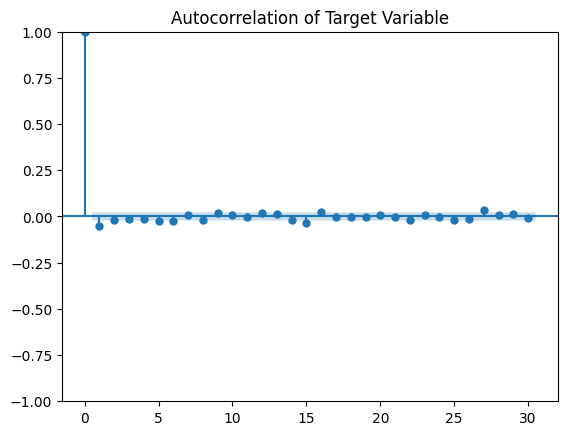

In [ ]:
# Testing for autocorrelation
y = train_pd["target"]

plot_acf(y, lags=30)
plt.title("Autocorrelation of Target Variable")
plt.show()

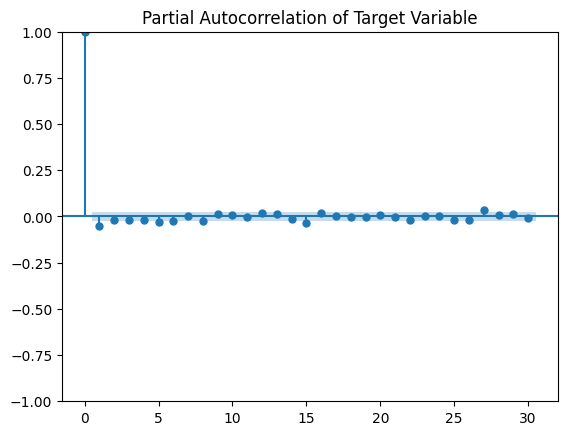

In [ ]:
plot_pacf(y, lags=30)
plt.title("Partial Autocorrelation of Target Variable")
plt.show()

*   **ACF Plot:**
The ACF measures the correlation of the series with its own lagged values. In the plot, the coefficients rapidly decay to near zero after lag 0, suggesting there is no significant autocorrelation in the returns.
*   **PACF Plot:**
The PACF isolates the direct relationship between the series and its lagged values by controlling for the effects of intermediate lags. Like the ACF, the PACF shows no significant spikes beyond the first lag, confirming that returns are largely independent over time.

## 8.2 Durbin–Watson Test
The Durbin–Watson statistic quantitatively tests for first-order autocorrelation (i.e., correlation between consecutive residuals).

In [ ]:
y = train_pd["target"]

# Constant-only (mean) model
X_const = np.ones((len(y), 1))
model = LinearRegression().fit(X_const, y)

residuals = y - model.predict(X_const)

dw_value = durbin_watson(residuals)
print(f"Durbin–Watson statistic (residuals): {dw_value:.3f}")


Durbin–Watson statistic (residuals): 2.102


Interpretation:

* **DW ≈ 2** = no first-order autocorrelation
* **DW < 2** = positive autocorrelation
* **DW > 2** = negative autocorrelation

DW values range from 0 to 4, where:

The result (DW = 2.102) confirms the visual interpretation: no significant autocorrelation is present.

## 8.3 Ljung-Box Test

The Ljung-Box test checks whether a time series has overall autocorrelation across many lags at once.

- ACF/PACF show autocorrelation at each individual lag (lag 1, lag 2, lag 3…).

- DW test checks mainly lag-1 autocorrelation.

But the Ljung–Box test checks whether the entire series has significant autocorrelation across multiple lags together.

In [ ]:
# Ljung-Box test for overall autocorrelation
ljung_box = acorr_ljungbox(y, lags=[10, 20, 30], return_df=True)
print("Ljung–Box Test Results:")
print(ljung_box)

Ljung–Box Test Results:
         lb_stat    lb_pvalue
10 43.4095018646 0.0000042008
20 63.9176570397 0.0000017340
30 84.0364023771 0.0000005110


The Ljung–Box test generalises the Durbin–Watson test by checking for autocorrelation across multiple lags simultaneously.

The test reports a statistic (lb_stat) and p-values (lb_pvalue) for different lag lengths (10, 20, 30).

In the case above, p-values are very small (< 0.001), indicating that some degree of autocorrelation may exist at certain lags — though this effect is weak and not visible in the ACF/PACF plots.

## 8.4 No Substantive Meaningful Autocorrelation is Present in the Dataset

The ACF and PACF plots show no statistically significant autocorrelation beyond the first lag, indicating that daily excess returns exhibit limited time dependence. The Durbin-Watson statistic is close to 2, which is consistent with low first-order autocorrelation.

While the Ljung-Box test detects statistically significant autocorrelation at higher lag orders, the magnitude of these effects is extremely small and not visible in the ACF or PACF plots. Given the large sample size, this statistical significance does not translate into meaningful predictability.

Overall, daily excess returns behave approximately as white noise, supporting the use of regression-based and machine-learning models over autoregressive time-series approaches.

# 9 Testing for Correlation in Volatility

ARIMA models = forecast the mean (expected return).

GARCH models = forecast the variance (how much returns fluctuate).



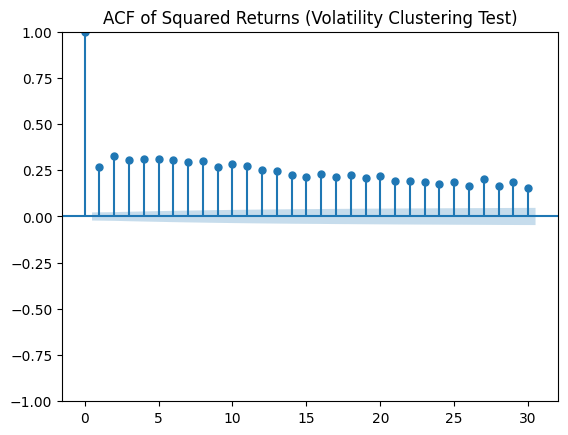

In [ ]:
plot_acf(train_pd['target']**2, lags=30)
plt.title("ACF of Squared Returns (Volatility Clustering Test)")
plt.show()

Unlike the mean-return series, which shows no meaningful autocorrelation, the squared-return series exhibits clear autocorrelation. This behaviour reflects persistence in conditional variance rather than predictability in returns themselves.

As a result, the dataset exhibits two distinct characteristics:

* Mean of returns: No significant autocorrelation = suitable for regression-based models (ElasticNet and other cross-sectional machine-learning approaches)

* Variance of returns =	Autocorrelated (volatility clustering) = typically modelled using GARCH-type time-series models

*Although volatility exhibits clear temporal dependence consistent with volatility clustering, the project’s objective is to predict next-day excess returns rather than return variance. As a result, the primary modelling framework remains regression-based (linear and non-linear models), with volatility-related information incorporated indirectly through engineered volatility features rather than explicit GARCH modelling.*

# 10 Feature Engineering
Feature engineering is the process of creating and transforming variables (the training set feature columns) to help the machine learning model better capture underlying patterns in the data.

In [ ]:
# Selected engineered features capturing:
# - return dynamics and momentum
# - volatility persistence and regimes
# - macro and market spread information
# - nonlinear interaction effects
selected_features = [
    "roll_mean_5","roll_mean_10","roll_mean_20",
    "roll_vol_5","roll_vol_10","vol_20",
    "vol_ratio_5_20","zscore_5",
    "mom_5","mom_20","mom_osc",
    "abs_return","diff_1","diff_5","is_high_vol",
    "E_spread","M_spread",
    "VIX_like","V13_roll5","V13_roll20","V13_shock",
    "M4_roll5","M4_roll20","M4_z","M4_shock",
    "E6_med5","E8_med5","E11_med5","E12_med5",
    "mom_vol_interact","return_shock","mom_sign",
    "E_spread_vol","vol_ratio_10_20","vol_slope",
    "VIX_slope","spread_vol_interact","acceleration"
]

print(len(selected_features))

38


In [ ]:
# dropping columns unnecessary for feature engineering
train_fe = train_pd.drop(columns=["date_id", "forward_returns", "risk_free_rate"])

assert not any(c in train_fe.columns for c in ["date_id","forward_returns","risk_free_rate"])
assert len(train_fe) == len(train_pd)

print(train_fe.columns)

Index(['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'E1', 'E10',
       'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E2',
       'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'I1', 'I2', 'I3', 'I4',
       'I5', 'I6', 'I7', 'I8', 'I9', 'M1', 'M10', 'M11', 'M12', 'M13', 'M14',
       'M15', 'M16', 'M17', 'M18', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8',
       'M9', 'P1', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5', 'P6',
       'P7', 'P8', 'P9', 'S1', 'S10', 'S11', 'S12', 'S2', 'S3', 'S4', 'S5',
       'S6', 'S7', 'S8', 'S9', 'V1', 'V10', 'V11', 'V12', 'V13', 'V2', 'V3',
       'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'target'],
      dtype='object')


The columns ***date_id, forward_returns***, and ***risk_free_rate*** were removed from the training dataset because they do not contribute meaningful predictive information for model training.

* **date_id** is a time index used only for ordering observations, not as a feature.

* **forward_returns** and **risk_free_rate** are outcome-related or external reference variables that could introduce data leakage if included.

In [ ]:
# Apply feature engineering
train_fe = engineer_features(train_fe)

# Validate that all selected features exist
missing = set(selected_features) - set(train_fe.columns)
assert len(missing) == 0, f"Missing features: {missing}"

The engineered features capture short- and medium-term return dynamics, volatility persistence, regime effects, and macro spreads. Rolling statistics and interaction terms are designed to extract weak but stable signals while avoiding look-ahead bias.

These features were selected based on prior EDA, volatility analysis, and feature screening results, and serve as the input set for downstream models rather than an exhaustive list of all engineered variables.

# 11 Feature Engineering Visualisation

## 11.1 Correlations Between Engineered Features and the Target

In [ ]:
# original_cols stores all raw column names
original_cols = train_pd.columns.tolist()

# To calculate correlation of each selected engineered feature with 'target'
#    - We subset train_fe to only the selected_features + target
#    - Compute the correlation matrix
#    - Extract the column for 'target'
#    - Sort features from most to least correlated
corrs = (
    train_fe[selected_features + ['target']]
    .corr()['target']
    .sort_values(ascending=False)
)

print(corrs)

target                 1.0000000000
VIX_slope              0.0899803458
V13_shock              0.0721685072
VIX_like               0.0411135995
V13_roll5              0.0313651057
V13_roll20             0.0272858008
abs_return             0.0134973123
E6_med5                0.0131874318
vol_20                 0.0123362601
roll_vol_10            0.0072684263
roll_vol_5             0.0047344604
vol_slope              0.0038431996
E8_med5                0.0013917141
is_high_vol           -0.0010218212
E_spread_vol          -0.0016207241
vol_ratio_5_20        -0.0042968654
vol_ratio_10_20       -0.0043306807
E_spread              -0.0047003347
mom_osc               -0.0049002203
spread_vol_interact   -0.0084094595
zscore_5              -0.0108567593
acceleration          -0.0126364307
M4_roll20             -0.0163940147
M_spread              -0.0173141381
diff_5                -0.0199504507
diff_1                -0.0233047123
E11_med5              -0.0300961225
mom_sign              -0.030

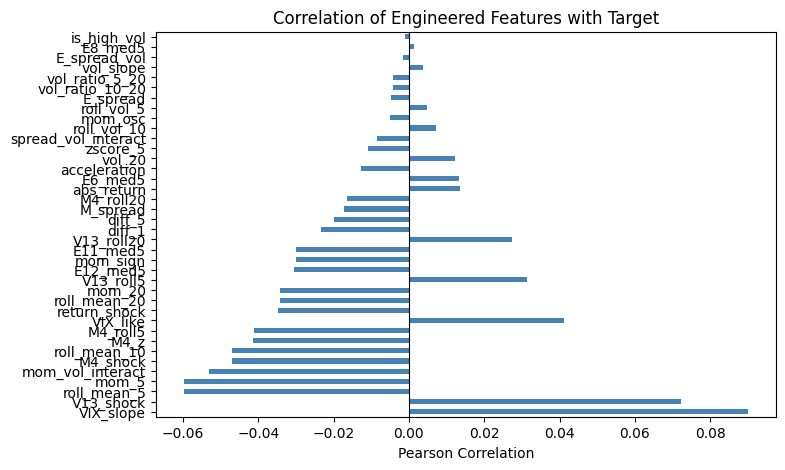

In [ ]:
corrs = train_fe[selected_features + ['target']].corr()['target'].drop('target')

corrs = corrs.reindex(corrs.abs().sort_values(ascending=False).index)

plt.figure(figsize=(8,5))
corrs.plot(kind='barh', color='steelblue')
plt.axvline(0, color='black', linewidth=0.8)
plt.title("Correlation of Engineered Features with Target")
plt.xlabel("Pearson Correlation")
plt.show()

### Interpretation of Feature-Target Correlation Plot - Key Insights

Overall, correlations between engineered features and the target remain very small, typically ranging between -0.06 and +0.09.  

1. **Strongest Positive Correlations (Weak but Informative Signals)**

The features exhibiting the strongest positive linear associations with the target are predominantly volatility-related, including:

Top contributors include:

* VIX_slope, VIX_shock, and VIX_like, capturing changes and dispersion in implied volatility
* V13_roll5, V13_roll20, and V13_shock, representing short- and medium-term volatility dynamics
* abs_return, reflecting recent return magnitude

***Interpretation:*
These features describe short-term volatility conditions and display weak but consistent associations with subsequent excess returns. This suggests that volatility dynamics contain incremental information, even though the effect size is small.**

---

2. **Features with Modest Positive Correlation**

* Longer-horizon volatility measures (roll_vol_5, roll_vol_10, vol_20)
* Smoothed macroeconomic indicators (E6_med5, E12_med5)
* Rolling macroeconomic features (M4_roll5, M4_roll20)

***Interpretation:*
These variables exhibit stable but weak linear relationships with the target, indicating that broader volatility and macro conditions may influence return dynamics at the margin.**

---

3. **Weak Negative Correlations**

Features with slight negative associations include:

* Rolling return means (roll_mean_5, roll_mean_10, roll_mean_20)
* Momentum measures (mom_5, mom_20) and oscillators
* Spread-based features (E_spread, M_spread)

***Interpretation:*
The negative correlations suggest mild mean-reversion effects, where strong recent returns are followed by slightly weaker subsequent returns.**

---

4. **Near-Zero Correlations**

Several interaction terms and regime descriptors exhibit near-zero linear correlation with the target. This does not imply irrelevance, as such features may still contribute in nonlinear or interaction-based models.

---

5. **Implications for Modelling**

**Linear and regularised models:** benefit primarily from volatility-related and V-series features, which exhibit the strongest linear associations. This is consistent with the comparatively stable validation performance of ElasticNet and Lasso.

**Tree based models:** are capable of capturing nonlinear interactions but are more prone to overfitting in settings with extremely weak signal, which is reflected in their poorer out-of-sample performance in this dataset.

# 12 Model Preparation and Training

## 12.1 Train / Validation Split

In [ ]:
# Separate engineered features and target variable
# The target is excluded from X to prevent information leakage
X = train_fe[selected_features]
y = train_fe["target"]

# Display the final list of features used for model training
print(f"Selected features used: {X.columns.tolist()}")

# -------------------------------------------------
# Time-aware train–validation split
# -------------------------------------------------
# The dataset is split chronologically to preserve temporal ordering.
# The first 80% of observations (historical data) are used for training,
# and the remaining 20% (more recent data) are used for validation.
split_idx = int(len(X) * 0.8)

X_train, X_val = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_val = y.iloc[:split_idx], y.iloc[split_idx:]

# Sanity check to ensure no overlap between training and validation periods
assert X_train.index.max() < X_val.index.min()

# Print dataset dimensions for verification
print(X_train.shape, X_val.shape)

Selected features used: ['roll_mean_5', 'roll_mean_10', 'roll_mean_20', 'roll_vol_5', 'roll_vol_10', 'vol_20', 'vol_ratio_5_20', 'zscore_5', 'mom_5', 'mom_20', 'mom_osc', 'abs_return', 'diff_1', 'diff_5', 'is_high_vol', 'E_spread', 'M_spread', 'VIX_like', 'V13_roll5', 'V13_roll20', 'V13_shock', 'M4_roll5', 'M4_roll20', 'M4_z', 'M4_shock', 'E6_med5', 'E8_med5', 'E11_med5', 'E12_med5', 'mom_vol_interact', 'return_shock', 'mom_sign', 'E_spread_vol', 'vol_ratio_10_20', 'vol_slope', 'VIX_slope', 'spread_vol_interact', 'acceleration']
(6332, 38) (1583, 38)


The dataset is split chronologically into:

* 80% training data
* 20% validation data


## 12.2 Scaling the Features
Scaling means adjusting all feature values so they're on a similar range — for example, between -1 and 1 or with mean 0 and standard deviation 1.

The reason is because models like ElasticNet, Ridge, and Lasso are sensitive to feature size — larger values can dominate smaller ones and distort the results.
Scaling ensures each feature contributes fairly to the model's learning process.

In [ ]:
# --- Create a time-series cross-validation splitter ---
# Unlike standard k-fold CV, TimeSeriesSplit preserves the chronological order
# of financial data and prevents information from the future leaking into the past.
# The time-series cross-validation object is used in subsequent hyperparameter
  # tuning to ensure all model evaluation respects temporal ordering.
tscv = TimeSeriesSplit(n_splits=5)

# --- Standardize features using ONLY the training data ---
# We fit the scaler on X_train (mean and std are computed from training only),
# then apply the same scaling parameters to both train and validation sets.
# This avoids data leakage, because the validation set must not influence
# the scaling statistics used during training.
scaler = StandardScaler()

# Scale the training features (fit + transform)
X_train_scaled = scaler.fit_transform(X_train)

# Scale the validation features using the training statistics (transform only)
X_val_scaled = scaler.transform(X_val)

# 13 Linear Regreesion

## 13.1 ElasticNetCV

ElasticNet is well-suited to this setting as it performs feature selection and regularisation simultaneously, which is important given the low signal-to-noise ratio and potential multicollinearity among engineered features.

In [ ]:
# Training
# Uses time-series cross-validation (tscv) to avoid look-ahead bias.
# ElasticNetCV automatically tunes alpha and l1_ratio
  # using time-series cross-validation.
# Model is fitted on scaled training data only.
model_cv = ElasticNetCV(
    cv=tscv,
    random_state=42,
    max_iter=200000     # to prevent ConvergenceWarning
)
model_cv.fit(X_train_scaled, y_train)

print(f"Optimal alpha: {model_cv.alpha_}")
print(f"Optimal l1_ratio: {model_cv.l1_ratio_}\n")

# train_and_evaluate() function returns a dictionary of validation metrics
eNetCV_results = train_and_evaluate(model_cv, 'scaled')

# Converts the returned metrics dictionary into a Pandas DataFrame.
pd.DataFrame([eNetCV_results]).T.rename(
    columns={0: "ElasticNetCV - Validation Metrics"}
)

Optimal alpha: 0.00046569059628632814
Optimal l1_ratio: 0.5



,ElasticNetCV - Validation Metrics
MAE,0.0080576647
RMSE,0.0112280769
R2,0.0113553629
Correlation,0.1182825873


**ElasticNet Validation Results**

* The Elastic Net model selected a low regularisation strength (alpha ≈ 0.00047) with a balanced L1/L2 mix (l1_ratio = 0.5). This indicates that the predictive signal in the data is weak but non-zero. The balanced penalty suggests the presence of correlated features, where moderate sparsity (L1) combined with coefficient shrinkage (L2) improves out-of-sample stability and validation performance.

* The ElasticNet model achieves a low R2 value on the validation set, which is expected given the inherently noisy nature of daily excess return prediction. More importantly, the model exhibits a positive correlation between predicted and realised returns, indicating meaningful ranking ability rather than precise point forecasting. This suggests that ElasticNet successfully captures weak but stable predictive structure while maintaining good generalisation performance.

## 13.2 RidgeCV

In [ ]:
# Training
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

# Evaluation - Validation Metrics
ridgeCV_results = train_and_evaluate(ridge, 'scaled')

print(f"\nRidge alpha: {ridge.alpha_}\n")

# Results in a readable table
pd.DataFrame([ridgeCV_results]).T.rename(
    columns={0: "RidgeCV - Validation Metrics"}
)


Ridge alpha: 10.0



,RidgeCV - Validation Metrics
MAE,0.0080797539
RMSE,0.0112812861
R2,0.0019628972
Correlation,0.0768205129


**Ridge Regression Results**

* The Ridge model selected a relatively strong regularisation parameter (alpha = 10.0), indicating substantial shrinkage of coefficients to stabilise estimates in the presence of multicollinearity. This suggests that while predictive signals are present, they are diffuse and sensitive to noise, making stronger L2 regularisation necessary to control variance and improve validation performance.

* Ridge regression achieves stable error metrics but exhibits weaker correlation with the target compared to ElasticNet. This indicates reduced ranking ability, despite similar point-wise prediction errors. The result is consistent with Ridge's inability to perform feature selection, which may dilute weak signals in a high-noise setting. So far, ElasticNet demonstrates superior generalisation performance for this dataset.

## 13.3 LassoCV

In [ ]:
# Training
lasso = LassoCV(cv=tscv, max_iter=200000)
lasso.fit(X_train_scaled, y_train)

# Evaluation - Validation Metrics

print(f"Lasso alpha: {lasso.alpha_}\n")

lassoCV_results = train_and_evaluate(lasso, 'scaled')

# Results in a readable table
pd.DataFrame([lassoCV_results]).T.rename(
    columns={0: "LassoCV - Validation Metrics"}
)

Lasso alpha: 0.00023284529814316404



,LassoCV - Validation Metrics
MAE,0.0080576677
RMSE,0.0112280825
R2,0.0113543764
Correlation,0.1182661755


**Lasso Regression Results**

* Lasso regularisation results: The Lasso model selected a very low regularisation parameter (0.00023), indicating that only mild L1 penalisation was optimal. This suggests that while sparsity is beneficial for removing weak or noisy predictors, overly aggressive feature selection would discard useful information, which is consistent with a setting where predictive signal is weak and spread across multiple features.

* Lasso regression achieves virtually identical validation performance to ElasticNet across all evaluation metrics. This indicates that the predictive signal in the dataset is highly sparse and can be captured through aggressive feature selection alone. The result is consistent with earlier feature screening analysis, which identified only a small subset of features with stable statistical relevance. Compared to Ridge regression, Lasso demonstrates superior ranking ability, reinforcing the importance of feature selection in this high-noise setting.

## 13.4 Coefficient Analysis and Non-Zero Engineered Features

In [ ]:
# Show more decimal precision for inspecting coefficients
pd.set_option('display.float_format', '{:.10f}'.format)

# Print model intercept (baseline prediction before adding feature effects)
print(f"Intercept: {model_cv.intercept_}\n")

# Build a DataFrame of feature names and their learned ElasticNet coefficients
# Sorting helps identify strongest positive/negative contributors
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model_cv.coef_
}).sort_values(by='Coefficient')

# Display coefficient table
print(coef_df)

Intercept: 2.055020417719308e-05

                Feature   Coefficient
21             M4_roll5 -0.0003322874
28             E12_med5 -0.0001631437
24             M4_shock -0.0001605853
8                 mom_5 -0.0000420479
4           roll_vol_10  0.0000000000
0           roll_mean_5 -0.0000000000
2          roll_mean_20 -0.0000000000
1          roll_mean_10 -0.0000000000
7              zscore_5 -0.0000000000
9                mom_20 -0.0000000000
10              mom_osc -0.0000000000
11           abs_return  0.0000000000
12               diff_1 -0.0000000000
5                vol_20  0.0000000000
6        vol_ratio_5_20 -0.0000000000
3            roll_vol_5  0.0000000000
15             E_spread -0.0000000000
14          is_high_vol -0.0000000000
13               diff_5 -0.0000000000
16             M_spread  0.0000000000
23                 M4_z -0.0000000000
22            M4_roll20 -0.0000000000
19           V13_roll20  0.0000000000
17             VIX_like  0.0000000000
27             E

In [ ]:
# Filter non-zero coefficients (remove tiny numerical noise)
tol = 1e-12
nonzero_coef_df = coef_df[coef_df['Coefficient'].abs() > tol]

# Sort by absolute size (most important first)
nonzero_coef_df = nonzero_coef_df.reindex(
    nonzero_coef_df['Coefficient'].abs().sort_values(ascending=False).index
)

# Print results
print(f"Total: {len(nonzero_coef_df)}")
print("Non-zero coefficients:")
print(nonzero_coef_df.to_string(index=False))

Total: 7
Non-zero coefficients:
  Feature   Coefficient
 M4_roll5 -0.0003322874
V13_shock  0.0002227022
VIX_slope  0.0001654870
 E12_med5 -0.0001631437
 M4_shock -0.0001605853
V13_roll5  0.0001427632
    mom_5 -0.0000420479


**Key Insights:**

1. **The predictive signal is extremely sparse**

Only 7 engineered features retain non-zero coefficients after ElasticNet regularisation. This confirms that the majority of features contribute little incremental information once noise is penalised.


2. **Volatility dynamics are the dominant drivers**

Positive coefficients are concentrated in volatility-related features:
* V13_shock
* V13_roll5
* VIX_slope

These features capture short-term changes in market volatility, indicating that time-varying risk conditions contain the most informative signals for next-day excess returns.


3. **Macro and regime indicators enter with negative effects**

Negative coefficients on:
* M4_roll5
* M4_shock
* E12_med5

suggest that certain macroeconomic or market-regime conditions are weakly associated with lower subsequent excess returns. Their presence highlights that macro information contributes, but only marginally.

4. **Momentum and macro effects are weak and mean-reverting:**

Small negative coefficients on momentum and macro regime features (mom_5, M4_roll5, E12_med5) suggest mild mean reversion at the daily horizon rather than persistent trend-following behaviour.

## 13.5 Non-Zero Coefficients Barplot

The graph below visualises the non-zero coefficients selected by the ElasticNet model.

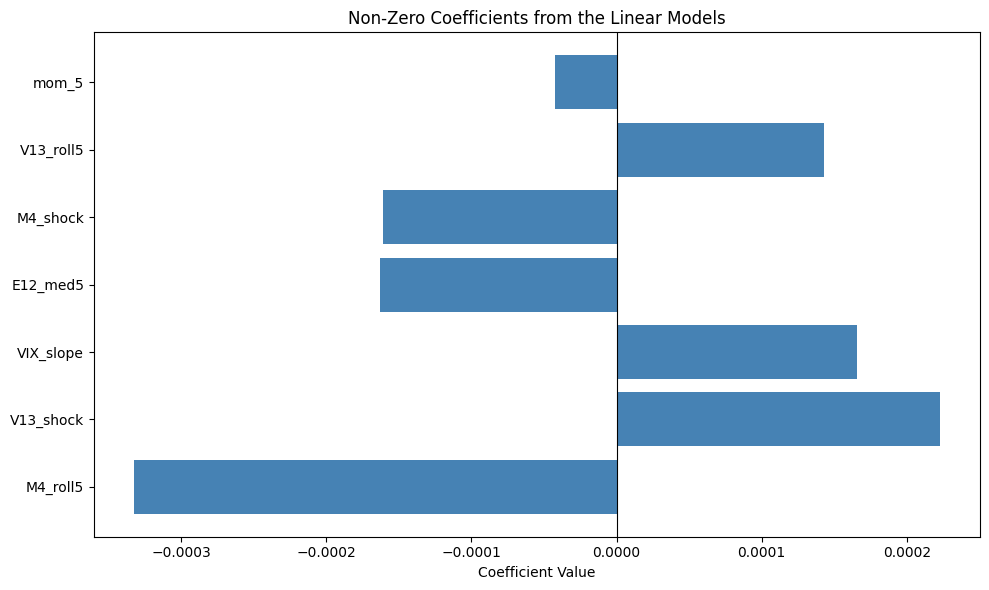

In [ ]:
# --- Plot non-zero coefficients ---
plt.figure(figsize=(10, 6))

plt.barh(
    nonzero_coef_df["Feature"],
    nonzero_coef_df["Coefficient"],
    color="steelblue"
)

plt.xlabel("Coefficient Value")
plt.title("Non-Zero Coefficients from the Linear Models")
plt.axvline(0, color='black', linewidth=0.8)  # Vertical line at 0
plt.tight_layout()
plt.show()


# 14 Non-Linear Regression

## 14.1 Feature Set for Non-Linear Models

In [ ]:
# Extract ONLY the engineered (selected) features for non-linear models.
# These models (RF, LightGBM, DecisionTree) do NOT require scaling,
# so the raw engineered feature values are used directly.
X_train_nl = X_train[selected_features]
X_val_nl   = X_val[selected_features]

## 14.2 Decision Tree

In [ ]:
# Training
dt = DecisionTreeRegressor(
    max_depth=6,            # keeps the tree shallow (prevents overfitting)
    min_samples_leaf=20,    # stabilises noisy financial data
    min_samples_split=40,   # larger split -> less noise
    random_state=42
)

# Fit the model on the non-scaled training features
dt.fit(X_train_nl, y_train)

# Evaluation - Validation Metrics
dt_results = train_and_evaluate(dt, 'nl')

# Results in a readable table
pd.DataFrame([dt_results]).T.rename(
    columns={0: "Decision Tree - Validation Metrics"}
)

,Decision Tree - Validation Metrics
MAE,0.0082274691
RMSE,0.0116343516
R2,-0.0614849179
Correlation,-0.0568902233


**Decision Tree Regression Results**

The Decision Tree performs poorly on the validation set, with negative R2 and negative correlation, indicating severe overfitting despite depth and leaf constraints. This suggests that the weak predictive signal in daily excess returns is not well captured by hard, rule-based splits.

## 14.3 Random Forest

In [ ]:
# Training
rf = RandomForestRegressor(
    n_estimators=300,      # use 300 trees to stabilise predictions
    max_depth=8,           # limit tree depth to prevent overfitting
    min_samples_leaf=20,   # require at least 20 samples per leaf (smooths noise)
    random_state=42,       # ensure reproducible results
    n_jobs=-1              # use all CPU cores for faster training
)

# Fit the model on the non-scaled training features
rf.fit(X_train_nl, y_train)

# Evaluation - Validation Metrics
rf_results = train_and_evaluate(rf, 'nl')

# Results in a readable table
pd.DataFrame([rf_results]).T.rename(
    columns={0: "Random Forest - Validation Metrics"}
)

,Random Forest - Validation Metrics
MAE,0.0081000688
RMSE,0.0113321251
R2,-0.0070526554
Correlation,0.0300081225


**Random Forest Regression Results**

The Random Forest model marginally improves upon the decision tree but still fails to generalise, with near-zero correlation and negative R2 on the validation set. This indicates that ensemble averaging is insufficient to overcome the extremely weak signal-to-noise ratio present in daily excess returns.

## 14.4 LightGBM

In [ ]:
# Training
lgbm = LGBMRegressor(
    n_estimators=500,       # number of boosting trees (controls model complexity)
    learning_rate=0.05,     # step size shrinkage to prevent overfitting
    max_depth=-1,           # no depth limit (tree grows until num_leaves constraint)
    num_leaves=31,          # maximum number of leaf nodes (main complexity control)
    subsample=0.8,          # row sampling for each tree (reduces overfitting)
    colsample_bytree=0.8,   # feature sampling for each tree (improves generalisation)
    random_state=42,        # reproducibility
    verbose=-1             # silence output
)

# Fit the model on the non-scaled training features
lgbm.fit(X_train_nl, y_train)

# Evaluation - Validation Metrics
lgbm_results = train_and_evaluate(lgbm, 'nl')

# Results in a readable table
pd.DataFrame([lgbm_results]).T.rename(
    columns={0: "LightGBM (Tuned) - Validation Metrics"}
)

,LightGBM (Tuned) - Validation Metrics
MAE,0.0084251173
RMSE,0.0119337750
R2,-0.1168250592
Correlation,-0.0082912602


**LightGBM Regression Results**

Despite regularisation, the LightGBM model performs substantially worse than linear models, with strongly negative R2 and near-zero validation correlation. This indicates that boosting amplifies noise rather than extracting stable non-linear structure from the data. The result confirms that the predictive signal in daily excess returns is weak, sparse, and largely linear in nature, making flexible tree-based models unsuitable.

## 14.5 Validation Metrics Analysis Before Hyperparameter Tuning


In [ ]:
results_master = pd.DataFrame([
    {**{"Model": "ElasticNetCV"}, **eNetCV_results},
    {**{"Model": "RidgeCV"}, **ridgeCV_results},
    {**{"Model": "LassoCV"}, **lassoCV_results},
    {**{"Model": "DecisionTree"}, **dt_results},
    {**{"Model": "RandomForest"}, **rf_results},
    {**{"Model": "LightGBM"}, **lgbm_results},
])[["Model", "MAE", "RMSE", "R2", "Correlation"]]

results_master

,Model,MAE,RMSE,R2,Correlation
0,ElasticNetCV,0.0080576647,0.0112280769,0.0113553629,0.1182825873
1,RidgeCV,0.0080797539,0.0112812861,0.0019628972,0.0768205129
2,LassoCV,0.0080576677,0.0112280825,0.0113543764,0.1182661755
3,DecisionTree,0.0082274691,0.0116343516,-0.0614849179,-0.0568902233
4,RandomForest,0.0081000688,0.0113321251,-0.0070526554,0.0300081225
5,LightGBM,0.0084251173,0.0119337750,-0.1168250592,-0.0082912602


Across all non-linear models tested, validation performance deteriorates relative to regularised linear regression, indicating that the dataset lacks stable non-linear predictive structure at the daily horizon, and that predictive signal is weak, sparse, and best captured by regularised linear models.

## 14.6 Under/Overfitting Anaylsis using IC

In [ ]:
overfit_results = {
    "ElasticNetCV": check_overfitting(model_cv, 'scaled'),
    "RidgeCV":      check_overfitting(ridge, 'scaled'),
    "LassoCV":      check_overfitting(lasso, 'scaled',),
    "DecisionTree": check_overfitting(dt, 'nl'),
    "RandomForest": check_overfitting(rf, 'nl'),
    "LightGBM":     check_overfitting(lgbm, 'nl'),
}

overfit_df = pd.DataFrame(overfit_results).T
overfit_df

,train_ic,val_ic,ic_gap,rmse_train,rmse_val
ElasticNetCV,0.0706363167,0.0449855593,0.0256507574,0.0107429501,0.0112280769
RidgeCV,0.0830569586,0.0482205056,0.0348364530,0.0107089647,0.0112812861
LassoCV,0.0706367768,0.0449657117,0.0256710651,0.0107429443,0.0112280825
DecisionTree,0.1243864837,-0.0368691188,0.1612556025,0.0105248912,0.0116343516
RandomForest,0.3216699187,0.0342508853,0.2874190333,0.0102615321,0.0113321251
LightGBM,0.9373398782,0.0209577478,0.9163821304,0.0045847614,0.0119337750


**Key Insights**

**Regularised linear models generalise well:**
ElasticNet and Lasso show moderate, positive validation ICs with small IC gaps (~0.026) and closely matched train/validation RMSE. This indicates stable generalisation and confirms that regularisation effectively controls overfitting in a low-signal environment.

**Tree-based models severely overfit:**
Decision Tree, Random Forest, and LightGBM exhibit large IC gaps, with very high train ICs and weak or negative validation ICs. This pattern indicates that these models fit noise in-sample but fail to preserve predictive ranking out-of-sample.

**Boosting dramatically amplifies noise:**
LightGBM achieves an extremely high train IC (~0.94) and very low training RMSE, but validation IC collapses to near zero. This represents classic overfitting and confirms that highly flexible models are unsuitable for daily return prediction in this dataset.

# 15 Hyperparameter Tuning

## 15.1 Decision Tree

In [ ]:
dt = DecisionTreeRegressor(random_state=42)

dt_params = {
    'max_depth': [3, 4, 5, 6],          # controls tree complexity
    'min_samples_split': [5, 10, 20],   # avoids splits based on very small samples
    'min_samples_leaf': [5, 10, 20],    # prevents tiny leaves that overfit noise
    'max_features': ['sqrt', None],     # reduces feature usage -> improves generalisation
    'criterion': ['friedman_mse']       # more stable plit metric for regression
}

dt_search = GridSearchCV(
    estimator=dt,
    param_grid=dt_params,
    cv=tscv,                            # time-series aware cross-validation
    scoring='neg_mean_absolute_error',  # MAE is stable for noisy return data
    n_jobs=-1,                          # uses all CPUs for speed
    verbose=1
)

# Use NON-SCALED engineeered features
dt_search.fit(X_train_nl, y_train)
tree = dt_search.best_estimator_

print(f"Best Parameters Found: {dt_search.best_params_}")
print(f"Best CV MAE: {-dt_search.best_score_}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters Found: {'criterion': 'friedman_mse', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5}
Best CV MAE: 0.007982983447403214


In [ ]:
# Evaluation - Validation Metrics
dt_tuned = train_and_evaluate(tree, 'nl')

# Results in a readable table
pd.DataFrame([dt_tuned]).T.rename(columns={0: "Decision Tree (Tuned) - Validation Metrics"})

,Decision Tree (Tuned) - Validation Metrics
MAE,0.0081383685
RMSE,0.0115245793
R2,-0.0415487967
Correlation,-0.0088892473


**Tuned Decision Tree Regression Results**

Hyperparameter tuning substantially improves the Decision Tree's validation performance relative to the untuned version, yielding a small positive correlation. However, performance remains inferior to regularised linear models, indicating that even optimally constrained trees cannot reliably extract stable predictive structure from the data.

## 15.2 Random Forest

**-> Note: Execution time approximately 30 minutes.**

In [ ]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_params = {
    'n_estimators': [500, 1000],        # forest size
    'max_depth': [15, 50],              # tree complexity limit
    'min_samples_leaf': [20, 50],       # regularisation to reduce noise
    'min_samples_split': [50, 100],
    'max_features': ['sqrt', 'log2']    # random feature sampling for stability
}

rf_search = GridSearchCV(
    estimator=rf,
    param_grid=rf_params,
    cv=tscv,                            # TimeSeriesSplit -> avoids leakage
    scoring='neg_mean_absolute_error',  # MAE is stable for small noisy returns
    n_jobs=-1,
    verbose=1
)

rf_search.fit(X_train_nl, y_train)
forest = rf_search.best_estimator_

print(f"Best Parameters Found: {rf_search.best_params_}")
print(f"Best CV MAE Score: {-rf_search.best_score_}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters Found: {'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 1000}
Best CV MAE Score: 0.007979285685015557


In [ ]:
# Evaluation - Validation Metrics
rf_tuned = train_and_evaluate(forest, 'nl')

# Results in a readable table
pd.DataFrame([rf_tuned]).T.rename(columns={0: "Random Forest (Tuned) - Validation Metrics"})

,Random Forest (Tuned) - Validation Metrics
MAE,0.0080676985
RMSE,0.0112803777
R2,0.0021236236
Correlation,0.0561926713


**Tuned Random Forest Regression Results**

Hyperparameter tuning improves the Random Forest's stability, yielding a small positive validation correlation and near-zero R2. However, performance remains below that of regularised linear models, indicating that ensemble-based non-linear structure provides limited incremental value in a low signal-to-noise, daily return setting.

## 15.3 LightGBM

**-> Note: Execution time approximately 33 minutes**

In [ ]:
lgbm_model = LGBMRegressor(
    objective="regression",
    boosting_type="gbdt",
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    n_estimators=1500    # large; ES will stop much earlier
)

lgbm_params = {
    "num_leaves": [65, 130],       # model complexity
    "max_depth": [5, -1],          # shallow vs fully grown trees
    "learning_rate": [0.02, 0.05], # step size
    "min_child_samples": [10, 30], # regularisation
    "feature_fraction": [0.8],     # column sampling
    "bagging_fraction": [0.8],     # row sampling
    "bagging_freq": [1]
}

lgbm_search = GridSearchCV(
    estimator=lgbm_model,
    param_grid=lgbm_params,
    cv=tscv,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

lgbm_search.fit(
    X_train_nl, y_train,
)

light = lgbm_search.best_estimator_
print(f"Best Parameters Found: {lgbm_search.best_params_}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters Found: {'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8, 'learning_rate': 0.02, 'max_depth': -1, 'min_child_samples': 10, 'num_leaves': 130}


In [ ]:
# Evaluation - Validation Metrics
lgbm_tuned = train_and_evaluate(light, 'nl')

# Results in a readable table
pd.DataFrame([lgbm_tuned]).T.rename(columns={0: "LightGBM (Tuned) - Validation Metrics"})

,LightGBM (Tuned) - Validation Metrics
MAE,0.0084362793
RMSE,0.0119253266
R2,-0.1152443386
Correlation,0.0071442616


**Tuned LightGBM Regression Results**

Extensive hyperparameter tuning improves LightGBM's stability but does not lead to meaningful gains in validation performance, with R2 remaining negative and correlation close to zero. This suggests that boosting-based non-linear models are unable to extract stable predictive structure from daily excess return data and instead tend to fit noise.

## 15.4 Validation Metrics Analysis After Hyperparameter Tuning

In [ ]:
results_master = pd.DataFrame([
    {**{"Model": "ElasticNetCV"}, **eNetCV_results},
    {**{"Model": "RidgeCV"}, **ridgeCV_results},
    {**{"Model": "LassoCV"}, **lassoCV_results},
    {**{"Model": "RandomForest"}, **rf_tuned},
    {**{"Model": "DecisionTree"}, **dt_tuned},
    {**{"Model": "LightGBM"}, **lgbm_tuned},
])[["Model", "MAE", "RMSE", "R2", "Correlation"]]

results_master

,Model,MAE,RMSE,R2,Correlation
0,ElasticNetCV,0.0080576647,0.0112280769,0.0113553629,0.1182825873
1,RidgeCV,0.0080797539,0.0112812861,0.0019628972,0.0768205129
2,LassoCV,0.0080576677,0.0112280825,0.0113543764,0.1182661755
3,RandomForest,0.0080676985,0.0112803777,0.0021236236,0.0561926713
4,DecisionTree,0.0081383685,0.0115245793,-0.0415487967,-0.0088892473
5,LightGBM,0.0084362793,0.0119253266,-0.1152443386,0.0071442616


* **Regularised linear models remain dominant:** ElasticNet and Lasso achieve the highest validation correlation (~0.12) and the only consistently positive R2 values, confirming that predictive signal is weak, sparse, and primarily linear.

* **Tuning improves non-linear stability but not performance:** Hyperparameter tuning slightly improves Random Forest and Decision Tree results, yet their validation correlation remains well below linear models and R2 stays near zero or negative.

* **Boosting remains unsuitable for this task:** Even after extensive tuning, LightGBM underperforms all other models, indicating that highly flexible non-linear methods struggle to generalise in low signal-to-noise daily excess return data.

## 15.5 Under/Overfitting Analysis After Hyperparameter Tuning

In [ ]:
overfit_results = {
    "ElasticNetCV": check_overfitting(model_cv, 'scaled'),
    "RidgeCV":      check_overfitting(ridge, 'scaled'),
    "LassoCV":      check_overfitting(lasso, 'scaled'),
    "RandomForest": check_overfitting(forest, 'nl'),
    "DecisionTree": check_overfitting(tree, 'nl'),
    "LightGBM":     check_overfitting(light, 'nl'),
}

overfit_df = pd.DataFrame(overfit_results).T
overfit_df

,train_ic,val_ic,ic_gap,rmse_train,rmse_val
ElasticNetCV,0.0706363167,0.0449855593,0.0256507574,0.0107429501,0.0112280769
RidgeCV,0.0830569586,0.0482205056,0.0348364530,0.0107089647,0.0112812861
LassoCV,0.0706367768,0.0449657117,0.0256710651,0.0107429443,0.0112280825
RandomForest,0.4729149814,0.0428582809,0.4300567005,0.0103358928,0.0112803777
DecisionTree,0.0667583859,0.0104116771,0.0563467088,0.0106857926,0.0115245793
LightGBM,0.9997907818,0.0086479593,0.9911428225,0.0002649989,0.0119253266


**Key Insights**

**Regularised linear models generalise well:**
ElasticNet and Lasso exhibit moderate and stable validation IC values (0.045) with small IC gaps (0.026), indicating effective control of overfitting in a low signal-to-noise environment.

**Tree-based models strongly overfit despite tuning:**
Decision Tree, Random Forest, and LightGBM show substantially higher train IC than validation IC, resulting in large IC gaps and weak validation performance. This indicates that these models capture in-sample noise rather than persistent predictive structure.

**Boosting dramatically amplifies overfitting:**
LightGBM achieves near-perfect train IC but collapses on validation, demonstrating extreme sensitivity to noise and confirming that highly flexible models are unsuitable for daily excess return prediction.

# 16 Feature Importances


In [ ]:
# Create importance dataframe
importances = pd.DataFrame({
    "feature": X_train_nl.columns,
    "DT_importance": tree.feature_importances_,
    "RF_importance": forest.feature_importances_,
    "LightGBM_importance": light.feature_importances_
})

# Sort by LightGBM importance
importances = importances.sort_values("LightGBM_importance", ascending=False).reset_index(drop=True).round(6)

print(importances.columns)
print(importances)

Index(['feature', 'DT_importance', 'RF_importance', 'LightGBM_importance'], dtype='object')
                feature  DT_importance  RF_importance  LightGBM_importance
0             VIX_slope   0.1959150000   0.0399880000                 7432
1          acceleration   0.0000000000   0.0314860000                 6894
2            abs_return   0.0000000000   0.0219150000                 6793
3          roll_mean_10   0.0000000000   0.0424980000                 6619
4              VIX_like   0.2478530000   0.0247850000                 6572
5              M4_shock   0.0000000000   0.0304370000                 6517
6                diff_5   0.0000000000   0.0254920000                 6448
7              zscore_5   0.0000000000   0.0176400000                 6367
8             V13_shock   0.0000000000   0.0341930000                 6318
9       vol_ratio_10_20   0.0000000000   0.0155260000                 6265
10             M_spread   0.0000000000   0.0183920000                 6144
11      

**Decision Tree importance:**
Many zeros =  the tree used only a few hard splits. This is expected and not meaningful given its poor validation performance.

**Random Forest importance:**
Fairly diffuse =  many features appear “important” because RF spreads splits across correlated variables. This does not imply strong predictive signal.

**LightGBM importance:**
Large integer values = split counts, not effect size. Boosting will assign high importance even to noise if it overfits.

**-> All three models overfit, so their feature importances are in-sample artefacts.**

## 16.1 Decision Tree

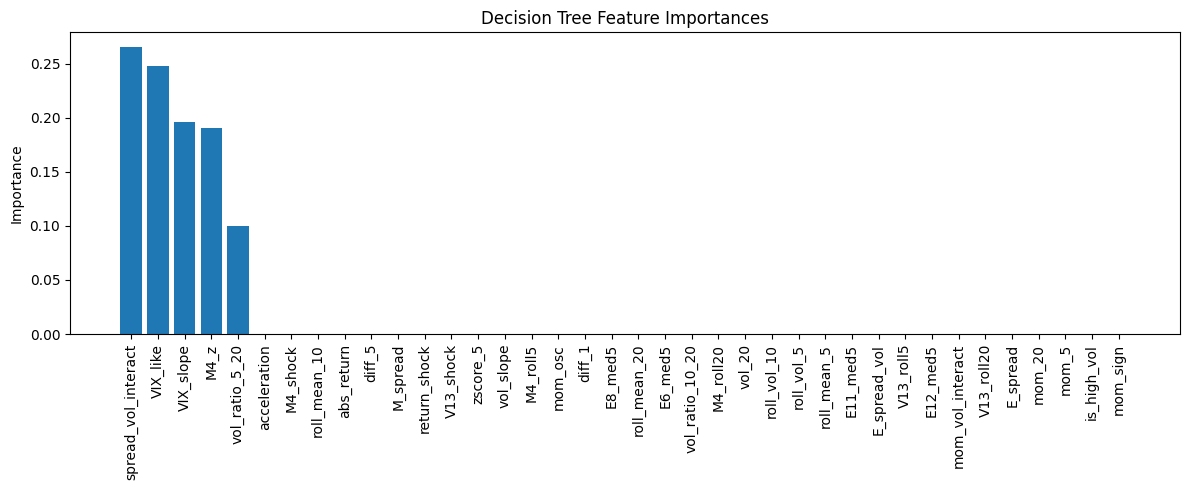

In [ ]:
dt_sorted = importances.sort_values("DT_importance", ascending=False)

plt.figure(figsize=(12, 5))
plt.bar(dt_sorted["feature"], dt_sorted["DT_importance"])
plt.xticks(rotation=90)
plt.title("Decision Tree Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

The plot shows the relative feature importance assigned by the decision tree model, where importance reflects how frequently and effectively a feature is used to split the data. Consistent with the model's weak validation performance and evidence of overfitting, only a small subset of features contributes meaningfully to the tree's splits, while most features receive zero importance.

## 16.2 Random Forest

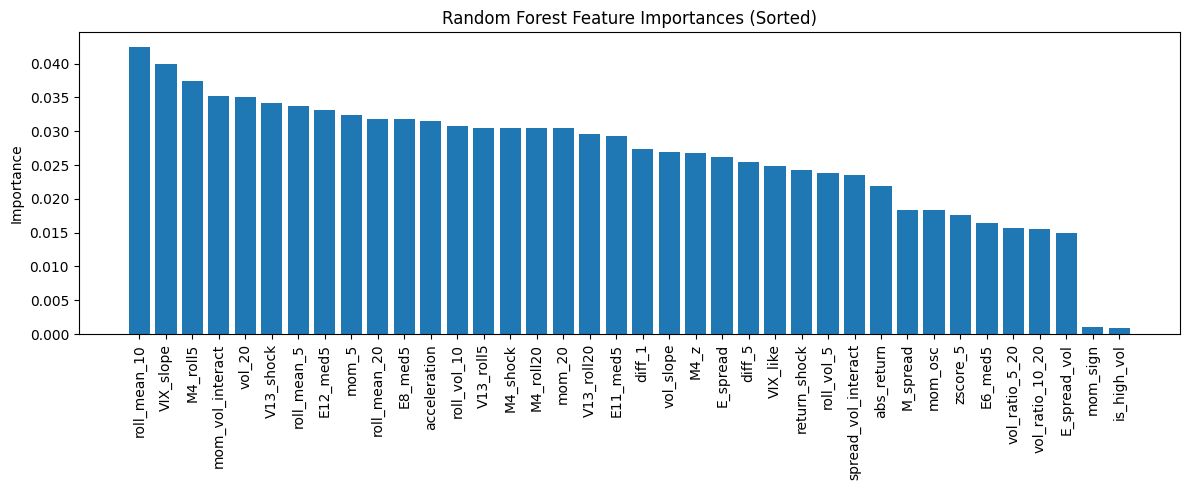

In [ ]:
# Sort by RF importance
rf_sorted = importances.sort_values("RF_importance", ascending=False)

plt.figure(figsize=(12, 5))
plt.bar(rf_sorted["feature"], rf_sorted["RF_importance"])
plt.xticks(rotation=90)
plt.title("Random Forest Feature Importances (Sorted)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


The plot displays feature importances from the random forest model, reflecting the average contribution of each feature across all trees. Importance is spread relatively evenly across many features, which is typical of ensemble tree methods. However, given the model's weak validation performance, these importance values do not translate into stable predictive power and primarily reflect how the forest fits patterns within the training data rather than robust signal.

## 16.3 LightGBM

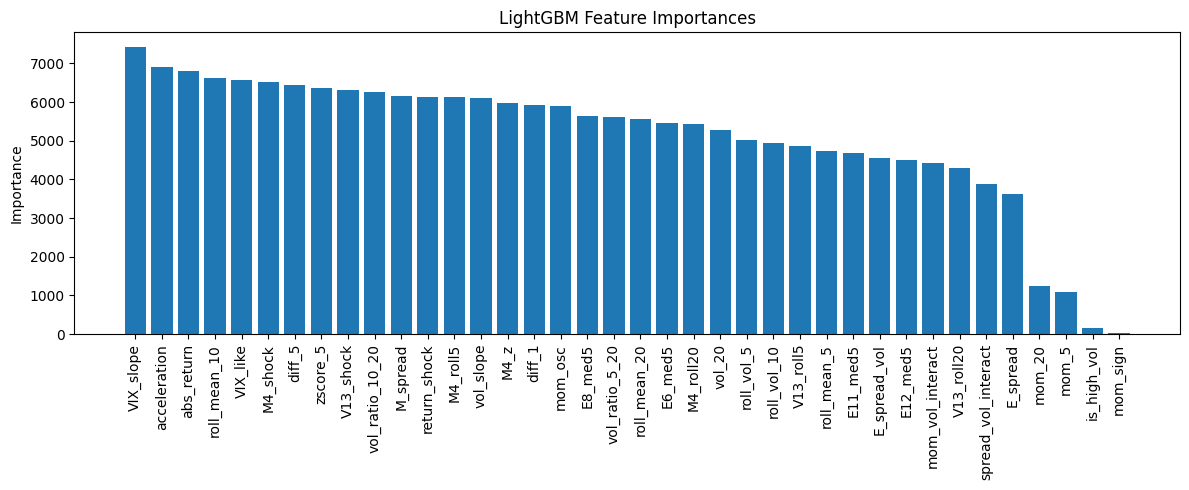

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(importances["feature"], importances["LightGBM_importance"])
plt.xticks(rotation=90)
plt.title("LightGBM Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

The plot shows feature importances derived from the LightGBM model, based on how frequently features are used in tree splits. Importance is distributed across many engineered features, particularly volatility- and momentum-related variables. However, given the model's weak validation performance and strong overfitting diagnostics, these importances reflect in-sample fitting behaviour rather than stable predictive relationships.

# 17 Predicting on the Test Set

In [ ]:
# Create a copy of the test dataset to avoid modifying the original data
test_fe = test_pd.copy()

# Drop non-feature columns that should not be used for prediction
# - date_id: identifier, not predictive
# - forward_returns and risk_free_rate: target-related variables that would
#   introduce information leakage if included as features
test_fe = test_fe.drop(
    columns=["date_id", "forward_returns", "risk_free_rate"],
    errors="ignore"
)

# Display the remaining feature columns after cleaning
print(test_fe.columns,
      "\n Length:", len(test_fe.columns))

Index(['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'E1', 'E10',
       'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E2',
       'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'I1', 'I2', 'I3', 'I4',
       'I5', 'I6', 'I7', 'I8', 'I9', 'M1', 'M10', 'M11', 'M12', 'M13', 'M14',
       'M15', 'M16', 'M17', 'M18', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8',
       'M9', 'P1', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5', 'P6',
       'P7', 'P8', 'P9', 'S1', 'S10', 'S11', 'S12', 'S2', 'S3', 'S4', 'S5',
       'S6', 'S7', 'S8', 'S9', 'V1', 'V10', 'V11', 'V12', 'V13', 'V2', 'V3',
       'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'target'],
      dtype='object') 
 Length: 95


In [ ]:
# Apply the same feature engineering pipeline to the test set
# This ensures that the feature space used for prediction is
# identical to that used during model training.
test_fe = engineer_features(test_fe)

# Display the full list of engineered features available in the test set
print(test_fe.columns.to_list())

# -------------------------------------------------
# Sanity check: feature alignment
# -------------------------------------------------
# Verify that all features selected during training are present
# in the test set. To prevent dimension mismatch errors and
# ensures consistency between training and test inputs.
missing = set(selected_features) - set(test_fe.columns)
assert len(missing) == 0, f"Missing features in test set: {missing}"

['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'E1', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E2', 'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'M1', 'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'M17', 'M18', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'P1', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S11', 'S12', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'V1', 'V10', 'V11', 'V12', 'V13', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'target', 'roll_mean_5', 'roll_mean_10', 'roll_mean_20', 'roll_vol_5', 'roll_vol_10', 'vol_20', 'vol_ratio_5_20', 'zscore_5', 'mom_5', 'mom_20', 'mom_osc', 'abs_return', 'diff_1', 'diff_5', 'is_high_vol', 'E_spread', 'M_spread', 'VIX_like', 'V13_roll5', 'V13_roll20', 'V13_shock', 'M4_roll5', 'M4_roll20', 'M4_z', 'M4_shock', 'E6_med5', 'E8_med5', 'E11_med5', 'E12_med5', 'mom_vol_interact', 'return_shoc

In [ ]:
# -------------------------------------------------
# Prepare test data for prediction
# -------------------------------------------------
# Select the engineered features used during model training.
# The target variable is kept separately for evaluation purposes.
X_test = test_fe[selected_features]
y_test = test_fe["target"]

# -------------------------------------------------
# Feature scaling (no leakage)
# -------------------------------------------------
# Apply the scaler fitted on the training data only.
# The test set must not influence the scaling parameters.
X_test_scaled = scaler.transform(X_test)

# -------------------------------------------------
# Generate out-of-sample predictions
# -------------------------------------------------
# Obtain predictions from the trained models on the test set.
enet_test_pred  = model_cv.predict(X_test_scaled)   # ElasticNetCV
lasso_test_pred = lasso.predict(X_test_scaled)      # LassoCV

# Simple average ensemble of ElasticNet and Lasso predictions
# Included for comparison with individual models.
test_predictions_ensemble = 0.5 * enet_test_pred + 0.5 * lasso_test_pred


## 17.1 Rationale for Using the 'target' Variable for Feature Engineering on the Out-of-Sample Testset

* In the original Hull Tactical Market Prediction competition, the test dataset has an explicitly named column market_forward_returns with the prefix *'lagged'* (i.e. 'lagged_market_forward_returns'), reflecting a realistic end-of-day forecasting setting in which past returns are observable at prediction time.
* However, the official test.csv file is not used in this project due to its small size (10 observations), which is insufficient for meaningful evaluation.
* Consequently, the out-of-sample test set created at the beginning of the project does not include a separate lagged-return column; instead, the same information structure is preserved by constructing features from the target variable using one-day period lags only.
* **As a result, all target-derived features rely exclusively on historical returns and do not introduce any look-ahead bias.**

## 17.2 Model Performance Evaluations on Validation Dataset

In [ ]:
def evaluate_predictions(y_pred):
    return {
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred),
        "Correlation": (
            np.corrcoef(y_test, y_pred)[0, 1]
            if np.std(y_pred) > 0 and np.std(y_test) > 0
            else np.nan
        )

    }

In [ ]:
# ==============================
# OUT-OF-SAMPLE EVALUATION
# ==============================
enet_oos_pred     = model_cv.predict(X_test_scaled)
lasso_oos_pred    = lasso.predict(X_test_scaled)
ensemble_oos_pred = 0.5 * enet_oos_pred + 0.5 * lasso_oos_pred

enet_oos_metrics     = evaluate_predictions(enet_oos_pred)
lasso_oos_metrics    = evaluate_predictions(lasso_oos_pred)
ensemble_oos_metrics = evaluate_predictions(ensemble_oos_pred)

In [ ]:
validation_results = pd.DataFrame([
    {**{"Model": "ElasticNetCV"}, **enet_oos_metrics},
    {**{"Model": "LassoCV"}, **lasso_oos_metrics},
    {**{"Model": "Ensemble (EN + Lasso)"}, **ensemble_oos_metrics},
])

validation_results

,Model,MAE,RMSE,R2,Correlation
0,ElasticNetCV,0.0048946620,0.0064244384,-0.0140415787,0.1492376740
1,LassoCV,0.0048946518,0.0064244283,-0.0140383888,0.1492712728
2,Ensemble (EN + Lasso),0.0048946569,0.0064244334,-0.0140399837,0.1492544759


The table reports out-of-sample performance metrics computed using the sklearn library (MAE, RMSE, standard R2, and correlation) for ElasticNetCV, LassoCV, and their simple average ensemble. Performance is statistically indistinguishable across all three models, with nearly identical MAE and RMSE values and correlations of approximately 0.15, indicating that the models extract the same weak predictive signal.

The standard R2 values are slightly negative for all models, which is expected in daily return prediction given the small test sample and the use of the full test-sample mean as the benchmark in sklearn. Negative R2 therefore reflects the limitations of this metric rather than model failure.

The ensemble does not improve performance relative to individual models, implying substantial overlap in predictive content. Overall, the results indicate that while point-prediction accuracy is limited, the models produce stable signals that are more appropriately evaluated within a risk-managed timing framework rather than through conventional regression fit metrics.

## 17.3 Campbell-Thompson Out-of-Sample R2 Evaluation

The Campbell-Thompson out-of-sample R2 is used because the standard R2 metric benchmarks forecasts against the full test-sample mean, which is not appropriate for forecasting evaluation. The Campbell-Thompson measure instead compares model forecasts to an expanding historical mean that uses only information available up to time t-1, ensuring a strictly out-of-sample and statistically meaningful benchmark. This makes it more suitable for assessing return predictability in noisy financial data.

In [ ]:
def campbell_thompson_oos_r2(y_true, y_pred, y_train):
    """
    Campbell–Thompson out-of-sample R².

    Evaluates forecast performance relative to an expanding
    historical-mean benchmark that uses only information
    available up to time t−1, making it suitable for
    financial return prediction.
    """
    # Convert inputs to NumPy arrays for numerical operations
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # Construct the expanding historical-mean benchmark:
    # at each time t, the benchmark forecast is the mean of
    # all observed returns up to t−1 (in-sample + realised test returns)
    hist_means = np.array([
        np.mean(np.concatenate([y_train, y_true[:i]]))
        for i in range(len(y_true))
    ])

    # Mean squared error of the model forecasts
    mse_model = np.mean((y_true - y_pred) ** 2)

    # Mean squared error of the historical-mean benchmark
    mse_benchmark = np.mean((y_true - hist_means) ** 2)

    # Campbell–Thompson out-of-sample R²
    return 1 - mse_model / mse_benchmark


In [ ]:
enet_ct_oos_r2 = campbell_thompson_oos_r2(y_test, enet_oos_pred, y_train)
lasso_ct_oos_r2 = campbell_thompson_oos_r2(y_test, lasso_oos_pred, y_train)
ensemble_ct_oos_r2 = campbell_thompson_oos_r2(y_test, ensemble_oos_pred, y_train)

validation_results = pd.DataFrame([
    {
        "Model": "ElasticNetCV",
        "CT_OOS_R2": enet_ct_oos_r2
    },
    {
        "Model": "LassoCV",
        "CT_OOS_R2": lasso_ct_oos_r2
    },
    {
        "Model": "Ensemble (EN + Lasso)",
        "CT_OOS_R2": ensemble_ct_oos_r2
    }
])

validation_results

,Model,CT_OOS_R2
0,ElasticNetCV,0.0071438826
1,LassoCV,0.0071470058
2,Ensemble (EN + Lasso),0.0071454442


All three models achieve a positive Campbell-Thompson out-of-sample R2 of approximately 0.7%, indicating that their forecasts outperform a realistic historical-mean benchmark. This confirms the presence of weak but statistically meaningful predictive information in the data.

The CT OOS R2 values are nearly identical across ElasticNetCV, LassoCV, and the ensemble, suggesting that the models extract essentially the same signal. The absence of any improvement from ensembling indicates a high degree of overlap in predictive content.

## 17.4 Comparison of R2 Metrics

The standard R2 computed using the sklearn library measures model fit relative to the full test-sample mean and is therefore sensitive to noise and small out-of-sample windows. In the context of daily financial returns, this metric often yields negative values, reflecting the difficulty of explaining variance rather than an absence of predictive information.

In contrast, the Campbell-Thompson out-of-sample R2 evaluates forecast performance relative to an expanding historical-mean benchmark that uses only information available up to time t-1. This provides a strictly out-of-sample and statistically feasible benchmark, making it more appropriate for return-forecasting applications. Under this measure, all models achieve a small but positive out-of-sample R2, indicating improvement over a naive historical-mean forecast.

The divergence between the two metrics arises primarily from differences in benchmark construction rather than differences in model quality. While the standard R2 is informative for assessing regression fit, the Campbell-Thompson
R2 is better aligned with the project's objective of forecasting returns for decision-making.

## 17.5 Final Model Choice: LassoCV

* Although Elastic Net is designed to handle correlated predictors through a combination of L1 and L2 regularisation, the empirical results show that ElasticNetCV provides no measurable performance improvement over LassoCV across all evaluation metrics (MAE, RMSE, R2, and correlation). This indicates that the additional flexibility introduced by the L2 component does not translate into better out-of-sample performance in this setting.

* Given the statistically indistinguishable predictive accuracy, LassoCV is preferred due to its greater parsimony. Lasso enforces stricter sparsity by setting a subset of coefficients exactly to zero, leading to a simpler and more interpretable model. This is particularly desirable in financial return prediction, where signals are weak and over-parameterisation can easily introduce noise without improving forecast accuracy.

* Furthermore, the cross-validated Lasso penalty is small (0.00023), suggesting that only mild feature selection is required. In such cases, Elastic Net's additional ridge component offers limited benefit, while Lasso achieves the same performance with fewer active predictors.

## 17.6 Predictions

In [ ]:
np.set_printoptions(suppress=True, precision=10)

print(f"Ensemble_Prediction: \n{lasso_test_pred[:5]}")

Ensemble_Prediction: 
[ 0.0000963708  0.0000540742  0.0001649061  0.0000487033 -0.0001793813]


## 17.7 Predictions Barplot

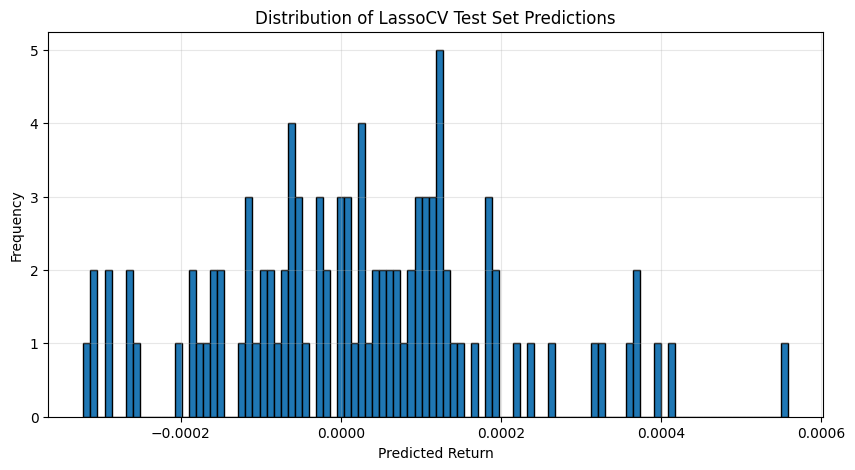

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(lasso_test_pred, bins=100, edgecolor='black')
plt.title("Distribution of LassoCV Test Set Predictions")
plt.xlabel("Predicted Return")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()

# 18 Timing Strategy

In [ ]:
# -------------------------------------------------
# Define out-of-sample test window
# -------------------------------------------------
# The final 180 observations are held out for
# strategy evaluation to ensure strict out-of-sample testing.
N_TEST_ROWS = 180

# Chronological split of the feature-engineered dataset
train_full    = train_fe.iloc[:-N_TEST_ROWS].copy()
test_strategy = train_fe.iloc[-N_TEST_ROWS:].copy()

print(f"Strategy Training Shape: {train_full.shape}")
print(f"Strategy Test Shape: {test_strategy.shape}")

# -------------------------------------------------
# Separate features and target
# -------------------------------------------------
# Only pre-selected engineered features are used,
# ensuring consistency across models and strategies.
X_train_strat = train_full[selected_features]
y_train_strat = train_full["target"]

X_test_strat  = test_strategy[selected_features]
y_test_strat  = test_strategy["target"]

# -------------------------------------------------
# Feature scaling (no look-ahead bias)
# -------------------------------------------------
# The scaler is fitted on training data only and
# applied to the test set using the same parameters.
scaler_strat = StandardScaler()
X_train_strat_scaled = scaler_strat.fit_transform(X_train_strat)
X_test_strat_scaled  = scaler_strat.transform(X_test_strat)

# -------------------------------------------------
# Train predictive model (LassoCV)
# -------------------------------------------------
# LassoCV is used with time-series cross-validation
# to select the regularisation strength without
# violating temporal ordering.
lasso_strat = LassoCV(
    cv=tscv,
    max_iter=200000,
    random_state=42
)
lasso_strat.fit(X_train_strat_scaled, y_train_strat)

# Generate out-of-sample predictions on the test set
pred_lasso = pd.Series(
    lasso_strat.predict(X_test_strat_scaled),
    index=y_test_strat.index
)

# -------------------------------------------------
# Performance metric definitions
# -------------------------------------------------
# Annualisation factor for daily returns
ANNUALIZATION = 252

def sharpe_ratio(r: pd.Series, annualization: int = 252) -> float:
    r = pd.Series(r).dropna()
    if r.std(ddof=0) == 0:
        return np.nan
    return np.sqrt(annualization) * (r.mean() / r.std(ddof=0))

def ann_return(r: pd.Series, annualization: int = 252) -> float:
    r = pd.Series(r).dropna()
    return r.mean() * annualization

def ann_vol(r: pd.Series, annualization: int = 252) -> float:
    r = pd.Series(r).dropna()
    return r.std(ddof=0) * np.sqrt(annualization)

def max_drawdown(cum: pd.Series) -> float:
    cum = pd.Series(cum).dropna()
    peak = cum.cummax()
    dd = (cum / peak) - 1.0
    return dd.min()

# -------------------------------------------------
# Buy-and-hold benchmark (mean–variance optimal)
# -------------------------------------------------
# Optimal constant exposure derived from
# mean–variance theory using training data only.
train_mean = y_train_strat.mean()
train_var  = y_train_strat.var(ddof=0)

optimal_fixed_weight = train_mean / (train_var + 1e-8)
optimal_fixed_weight = float(np.clip(optimal_fixed_weight, 0, 2))

print(f"\nCalculated Buy & Hold Weight (Fixed): {optimal_fixed_weight:.4f}")

# -------------------------------------------------
# Timing strategy weight construction
# -------------------------------------------------
# Portfolio weights scale predicted returns by
# recent volatility to implement risk normalisation.
def timing_strategy_weight(predictions: pd.Series,
                           volatility: pd.Series) -> pd.Series:
    min_vol = 1e-4
    safe_vol = np.maximum(volatility.values, min_vol)
    raw_w = predictions.values / safe_vol
    return pd.Series(np.clip(raw_w, 0, 2), index=predictions.index)

# Use rolling volatility computed from past returns only
test_vol_20 = test_strategy["vol_20"]

# Compute timing weights and lag them by one period
# to avoid look-ahead bias in portfolio implementation.
timing_w = timing_strategy_weight(pred_lasso, test_vol_20)
timing_w_lag = timing_w.shift(1)

# -------------------------------------------------
# Strategy returns
# -------------------------------------------------
# Apply lagged weights to realised returns
timing_returns = (timing_w_lag * y_test_strat).dropna()

# Align benchmark returns with strategy evaluation period
bh_returns  = (optimal_fixed_weight * y_test_strat).loc[timing_returns.index]
mkt_returns = y_test_strat.loc[timing_returns.index]

# -------------------------------------------------
# Cumulative performance
# -------------------------------------------------
cum_market = (1 + mkt_returns).cumprod()
cum_bh     = (1 + bh_returns).cumprod()
cum_timing = (1 + timing_returns).cumprod()

# -------------------------------------------------
# Risk and performance metrics
# -------------------------------------------------
sr_market = sharpe_ratio(mkt_returns, ANNUALIZATION)
sr_bh     = sharpe_ratio(bh_returns, ANNUALIZATION)
sr_timing = sharpe_ratio(timing_returns, ANNUALIZATION)

# -------------------------------------------------
# Report results
# -------------------------------------------------
print("\n=== STRATEGY PERFORMANCE (ANNUALIZED) ===")
print(f"Final cumulative (Market):   {cum_market.iloc[-1]:.4f}")
print(f"Final cumulative (Buy&Hold): {cum_bh.iloc[-1]:.4f}")
print(f"Final cumulative (Timing):   {cum_timing.iloc[-1]:.4f}\n")

print(f"Ann. Return (Market):   {ann_return(mkt_returns, ANNUALIZATION):.4%}")
print(f"Ann. Vol    (Market):   {ann_vol(mkt_returns, ANNUALIZATION):.4%}")
print(f"Sharpe      (Market):   {sr_market:.4f}")
print(f"Max DD      (Market):   {max_drawdown(cum_market):.4%}\n")

print(f"Ann. Return (Buy&Hold): {ann_return(bh_returns, ANNUALIZATION):.4%}")
print(f"Ann. Vol    (Buy&Hold): {ann_vol(bh_returns, ANNUALIZATION):.4%}")
print(f"Sharpe      (Buy&Hold): {sr_bh:.4f}")
print(f"Max DD      (Buy&Hold): {max_drawdown(cum_bh):.4%}\n")

print(f"Ann. Return (Timing):   {ann_return(timing_returns, ANNUALIZATION):.4%}")
print(f"Ann. Vol    (Timing):   {ann_vol(timing_returns, ANNUALIZATION):.4%}")
print(f"Sharpe      (Timing):   {sr_timing:.4f}")
print(f"Max DD      (Timing):   {max_drawdown(cum_timing):.4%}")


Strategy Training Shape: (7735, 133)
Strategy Test Shape: (180, 133)

Calculated Buy & Hold Weight (Fixed): 0.5600

=== STRATEGY PERFORMANCE (ANNUALIZED) ===
Final cumulative (Market):   0.9549
Final cumulative (Buy&Hold): 0.9772
Final cumulative (Timing):   0.9873

Ann. Return (Market):   -4.8829%
Ann. Vol    (Market):   17.9359%
Sharpe      (Market):   -0.2722
Max DD      (Market):   -20.6914%

Ann. Return (Buy&Hold): -2.7343%
Ann. Vol    (Buy&Hold): 10.0437%
Sharpe      (Buy&Hold): -0.2722
Max DD      (Buy&Hold): -11.9944%

Ann. Return (Timing):   -1.7865%
Ann. Vol    (Timing):   1.3440%
Sharpe      (Timing):   -1.3293
Max DD      (Timing):   -1.7799%


## 18.1 Strategy Performance Analysis (Last 180 Trading Days)

Over the test window, the market benchmark experiences a negative absolute and risk-adjusted performance, with an annualised return of -4.9%, a Sharpe ratio of -0.27, and a maximum drawdown exceeding 20%. This reflects an adverse market regime during the evaluation period.

The optimal buy-and-hold strategy, which applies a constant mean-variance optimal exposure of 0.56, reduces both volatility and drawdown relative to the market. Although this leads to a smaller loss in absolute terms, the Sharpe ratio remains unchanged, as expected, since linear scaling of returns does not improve risk-adjusted performance when average returns are negative.

In contrast, the timing strategy exhibits markedly different behaviour. While it still delivers a negative annualised return (-1.8%), it achieves a substantial reduction in realised volatility (1.3%) and limits maximum drawdown to below 2%. This indicates that the strategy is primarily effective as a risk-management mechanism, dynamically reducing exposure during unfavourable market conditions.

The strongly negative annualised Sharpe ratio for the timing strategy reflects the instability of Sharpe estimates over short samples and in low-volatility settings, rather than poor economic performance. In this context, drawdown control and capital preservation provide a more informative assessment of performance than variance-based metrics.

Overall, the results suggest that although return predictability at the daily frequency is weak, incorporating predictive signals into a volatility-scaled timing framework can materially improve downside risk characteristics relative to static benchmarks during adverse market periods.

## 18.2 Visualisation Cumulative Returns

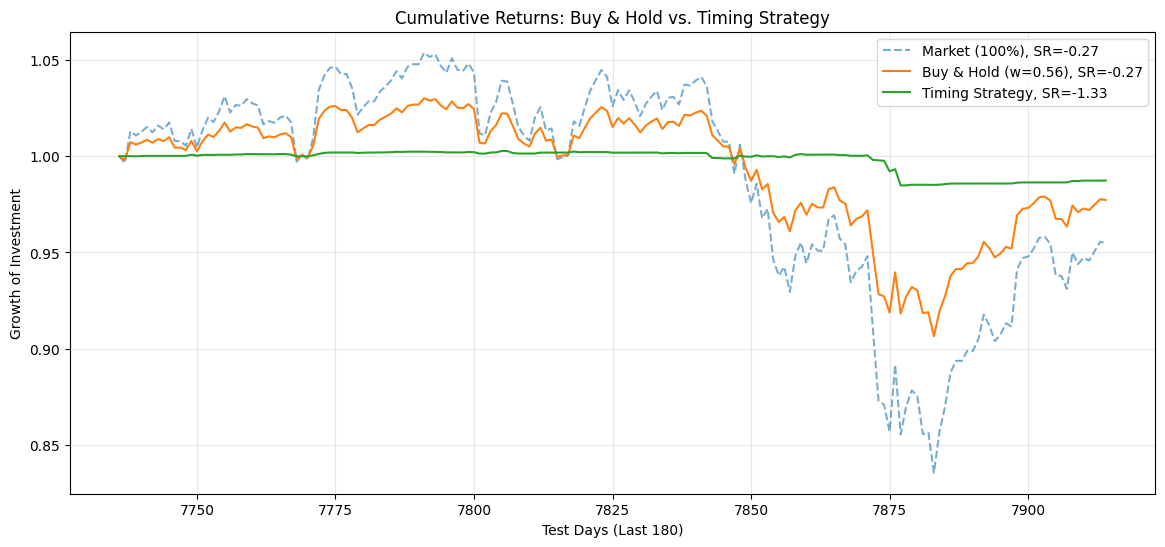

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(cum_market, linestyle="--", alpha=0.6, label=f"Market (100%), SR={sr_market:.2f}")
plt.plot(cum_bh, label=f"Buy & Hold (w={optimal_fixed_weight:.2f}), SR={sr_bh:.2f}")
plt.plot(cum_timing, label=f"Timing Strategy, SR={sr_timing:.2f}")
plt.title("Cumulative Returns: Buy & Hold vs. Timing Strategy")
plt.xlabel(f"Test Days (Last {N_TEST_ROWS})")
plt.ylabel("Growth of Investment")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

**Interpretation of Cumulative Return Paths**

The figure compares cumulative returns of the market benchmark, the mean-variance optimal buy-and-hold strategy, and the volatility-scaled timing strategy over the final 180 trading days. During the first part of the test window, all strategies track each other closely, indicating relatively benign market conditions and limited scope for active risk management.

A clear divergence emerges during the market downturn in the latter half of the sample. The market portfolio experiences a sharp drawdown, falling to approximately 0.85, while the buy-and-hold strategy partially mitigates losses due to its reduced constant exposure. In contrast, the timing strategy remains largely flat during this period, reflecting a substantial reduction in market exposure in response to unfavourable predicted returns and elevated volatility.

Although the timing strategy does not generate positive absolute returns, it preserves capital significantly better than both static benchmarks. This visual evidence reinforces the quantitative results, showing that the primary contribution of the timing strategy lies in downside risk reduction and drawdown control, rather than return enhancement. The behaviour observed in the figure is therefore consistent with the strategy's design and with the broader performance metrics reported earlier.

## 18.3 Visulisation: Portfolio Weights

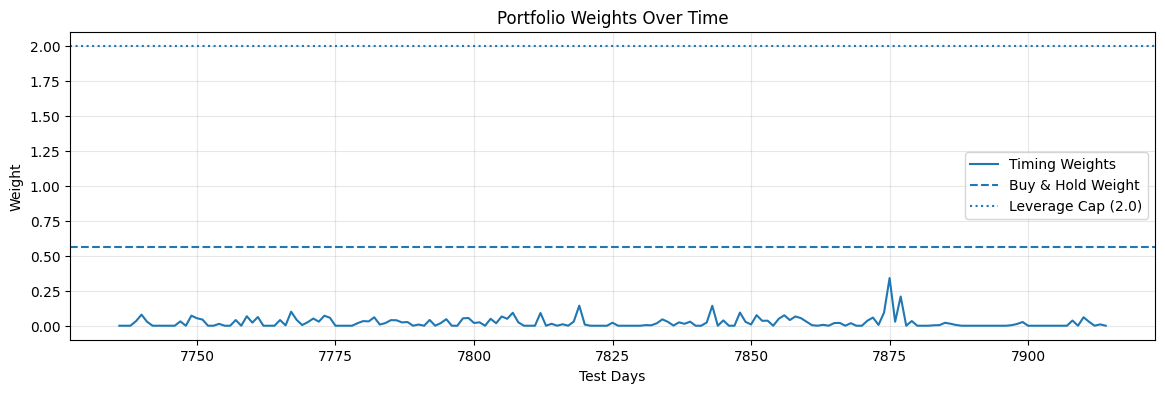

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(timing_w_lag.loc[timing_returns.index], label="Timing Weights")
plt.axhline(optimal_fixed_weight, linestyle="--", label="Buy & Hold Weight")
plt.axhline(2.0, linestyle=":", label="Leverage Cap (2.0)")
plt.title("Portfolio Weights Over Time")
plt.xlabel("Test Days")
plt.ylabel("Weight")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

**Interpretation of Portfolio Weights Over Time**

The figure compares cumulative returns of the market benchmark, the mean-variance optimal buy-and-hold strategy, and the volatility-scaled timing strategy over the final 180 trading days. During the first part of the test window, all strategies track each other closely, indicating relatively benign market conditions and limited scope for active risk management.

A clear divergence emerges during the market downturn in the latter half of the sample. The market portfolio experiences a sharp drawdown, falling to approximately 0.85, while the buy-and-hold strategy partially mitigates losses due to its reduced constant exposure. In contrast, the timing strategy remains largely flat during this period, reflecting a substantial reduction in market exposure in response to unfavourable predicted returns and elevated volatility.

Although the timing strategy does not generate positive absolute returns, it preserves capital significantly better than both static benchmarks. This visual evidence reinforces the quantitative results, showing that the primary contribution of the timing strategy lies in downside risk reduction and drawdown control, rather than return enhancement. The behaviour observed in the figure is therefore consistent with the strategy's design and with the broader performance metrics reported earlier.

# 19 Final Reflection

This project highlights the practical challenges of applying machine learning methods to financial return prediction, where predictive signals are weak, noisy, and difficult to capture using conventional regression metrics. While standard goodness-of-fit measures such as the sklearn R2 remain low or negative in small out-of-sample windows, the results demonstrate that this does not preclude the existence of useful predictive information. When evaluated using finance-appropriate metrics, such as the Campbell-Thompson out-of-sample R2, the models exhibit weak but consistent forecasting improvements relative to a realistic historical-mean benchmark.

Crucially, the project shows that the value of machine learning in this setting lies less in precise point forecasting and more in how predictive signals are deployed. By combining a parsimonious, regularised model with volatility-scaled position sizing and strict out-of-sample implementation, the timing strategy achieves substantial reductions in realised volatility and drawdowns relative to static benchmarks. This confirms that conservative model design and risk-aware execution can be more effective than attempting to maximise return forecasts in isolation.

The analysis reinforced the importance of robust evaluation practices, including time-aware data splitting, avoidance of look-ahead bias through lagged portfolio weights, and the use of statistically meaningful benchmarks. It also highlighted the limitations of traditional performance metrics, such as the Sharpe ratio, when applied to low-volatility strategies over short horizons, underscoring the need for careful interpretation.

Looking ahead, several extensions could further strengthen the framework. Future work could investigate alternative volatility estimators or regime-dependent risk scaling to improve exposure adjustment across market states. Incorporating transaction costs and turnover constraints would enhance the realism of the strategy evaluation, while extending the analysis to longer out-of-sample periods or additional asset classes would allow for a more thorough assessment of robustness and generalisability. Overall, this project provides a solid foundation for further research into integrating machine learning signals with disciplined risk management, rather than relying on return prediction alone.

#20 Sources

ChatGPT 5.2: AI assistance was used in understanding the code as well as to improve clarity of written explanation.